<a href="https://colab.research.google.com/github/thc1006/flora-dp-federated-ColO-RAN/blob/main/0707_FLORA_DP_client_15_v1_1_0(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Cell 1: 環境設定與函式庫匯入（強化版）
# 修正：安裝 nest_asyncio
!pip install --upgrade opacus -q
!pip install nest_asyncio -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, random, copy, json, os, time, warnings, math, re, contextlib
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from dataclasses import dataclass, asdict
from sklearn.cluster import KMeans
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader
from typing import Dict, List, Tuple, Optional, Union
import scipy.stats as stats
from datetime import datetime
import nest_asyncio # 修正：匯入 nest_asyncio

# --- 環境設定 ---
try: torch._dynamo.disable()
except Exception: pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message=".*overflow encountered.*", category=RuntimeWarning)

pd.options.mode.chained_assignment = None

# --- 新增：Deterministic 設定 (任務6) ---
def set_global_seed(seed: int = 42):
    """設定全局隨機種子以確保可重現性"""
    # 修正：設定 CUBLAS_WORKSPACE_CONFIG 環境變數
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 確保 deterministic 行為
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if hasattr(torch, 'use_deterministic_algorithms'):
        try:
            torch.use_deterministic_algorithms(True)
        except RuntimeError:
            # 某些操作可能不支援 deterministic
            print("⚠️ 部分操作不支援完全 deterministic 模式")

set_global_seed(42)

# 修正：應用 nest_asyncio
nest_asyncio.apply()

print("✅ Cell 1: 環境與函式庫準備就緒（含 Deterministic 與 Asyncio 修正）。")
import opacus
print(f"PyTorch/Opacus 版本: {torch.__version__} / {opacus.__version__}")
print(f"CUDA 是否可用: {torch.cuda.is_available()}")
print(f"Deterministic 模式: 已啟用")
print(f"Nest Asyncio: 已應用")

✅ Cell 1: 環境與函式庫準備就緒（含 Deterministic 與 Asyncio 修正）。
PyTorch/Opacus 版本: 2.6.0+cu124 / 1.5.4
CUDA 是否可用: True
Deterministic 模式: 已啟用
Nest Asyncio: 已應用


In [ ]:
# @title Cell 2: 🎓 實驗參數設定（強化版 - 支援 Non-IID & CQL）
from dataclasses import dataclass, field
import os
import json
import torch
import numpy as np
from typing import Tuple

@dataclass
class TrainingConfig:
    experiment_name: str
    output_dir: str
    mode: str = "ClusteredFL"  # 新增支援: "CQL"
    random_seed: int = 42
    comm_rounds: int = 20

    # 【新增】Non-IID 配置 (任務1)
    enable_non_iid: bool = True
    dirichlet_alpha: float = 0.5  # 控制 Non-IID 程度，越小越異質
    min_clients_non_iid: int = 10  # 最少客戶端數量

    # 【新增】CQL 配置 (任務2)
    enable_cql: bool = False
    cql_alpha: float = 1.0  # CQL 保守性權重
    cql_min_q_weight: float = 5.0  # 最小 Q 值懲罰權重

    # 【新增】Adaptive Clipping 配置 (任務3)
    enable_adaptive_clip: bool = True
    clip_window: int = 50  # 統計窗口大小
    clip_percentile: float = 0.9  # 使用 90 分位數

    # 【新增】非同步聚合配置 (任務4)
    enable_async_aggregation: bool = True
    timeout_threshold: float = 0.3  # 30% 客戶端超時觸發非同步
    client_timeout_seconds: float = 30.0  # 客戶端超時時間

    # 虛擬客戶端相關（保留原有）
    base_client_pairs: tuple = ((1, 2), (3, 7), (5, 6))
    virtual_expansion_factor: int = 3
    num_virtual_clients: int = 9
    num_real_clients: int = 3
    total_clients: int = 12
    num_clients: int = 12
    num_clients_to_select: int = 8

    # 其他原有參數保持不變
    temporal_split_method: str = "sliding_window"
    noise_injection_std: float = 0.03
    feature_augmentation: bool = True
    cross_validation_split: bool = True

    local_episodes_per_round: int = 4
    steps_per_episode: int = 500
    batch_size: int = 256
    gamma: float = 0.99

    lr: float = 1e-4
    target_update_freq: int = 15

    epsilon_start: float = 1.0
    epsilon_decay: float = 0.9995
    epsilon_min: float = 0.05

    memory_capacity: int = 50000
    replay_start_size: int = 1000
    replay_frequency: int = 2
    replay_batches_per_call: int = 3

    fedprox_mu: float = 0.15
    num_clusters: int = 3
    cluster_update_freq: int = 8

    enable_dp: bool = True
    dp_target_epsilon: float = 8.0
    dp_target_delta: float = 1e-5
    dp_max_grad_norm: float = 1.0
    dp_noise_multiplier: float = 0.5
    dp_sampling_probability: float = 0.1
    dp_virtual_batch_size: int = 256
    dp_microbatch_size: int = 1

    dp_reset_threshold_multiplier: float = 1.5
    enable_dp_reset: bool = True

    enable_heterogeneity: bool = True
    enable_compression: bool = True

    straggler_ratio: float = 0.1
    dropout_ratio: float = 0.05
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True
    local_finetune_episodes: int = 15
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    client_pairs: tuple = field(init=False)

    def __post_init__(self):
        # 動態生成客戶端配對
        extended_client_pairs = []
        for i in range(self.total_clients):
            embb_id = i + 1
            urllc_id = i + 2
            extended_client_pairs.append((embb_id, urllc_id))
        self.client_pairs = tuple(extended_client_pairs)

        # GPU 環境檢測
        if torch.cuda.is_available():
            if "L4" in torch.cuda.get_device_name(0):
                print(f"🚀 L4 GPU檢測到，啟用大批次優化配置")

        # 差分隱私模式檢測
        if self.mode == 'Centralized':
            self.enable_dp = False

        # CQL 模式檢測
        if self.mode == 'CQL':
            self.enable_cql = True
            print(f"🎯 CQL 模式啟用 - α={self.cql_alpha}, min_q_weight={self.cql_min_q_weight}")

        # 配置信息顯示
        print(f"🔄 實驗配置:")
        print(f"   - Non-IID: {'啟用' if self.enable_non_iid else '禁用'} (α={self.dirichlet_alpha})")
        print(f"   - Adaptive Clipping: {'啟用' if self.enable_adaptive_clip else '禁用'}")
        print(f"   - 非同步聚合: {'啟用' if self.enable_async_aggregation else '禁用'}")
        print(f"   - 總客戶端數: {self.total_clients}")

        if self.enable_dp and self.mode != 'Centralized':
            print(f"🛡️ 差分隱私已啟用")
            print(f"   - 目標隱私預算: ε={self.dp_target_epsilon}")
            print(f"   - 批次大小: {self.batch_size}")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in self.__dict__.items()}
        with open(path, 'w') as f:
            json.dump(config_dict, f, indent=4)
        print(f"✅ 配置已保存至: {path}")

print("✅ Cell 2: TrainingConfig（強化版）定義完成。")

✅ Cell 2: TrainingConfig（強化版）定義完成。


In [ ]:
# @title Cell 3: 🧩 數據與環境準備（支援 Non-IID 分配）
class DataManager:
    def __init__(self, data_path, client_pairs_config, enable_non_iid=False,
                 dirichlet_alpha=0.5, min_clients=10):
        print(f"\n[DataManager] 正在從 {data_path} 讀取數據...")
        self.df_kpi = pd.read_parquet(data_path)
        self.client_pairs_config = client_pairs_config
        self.enable_non_iid = enable_non_iid
        self.dirichlet_alpha = dirichlet_alpha
        self.min_clients = min_clients
        self._sanitize_column_names()
        self._preflight_check()

    def _sanitize_column_names(self):
        sanitized_columns = [re.sub(r'[\\[\\]\\(\\)%\\s\\.-]+', '_', col.strip().lower()).strip('_')
                           for col in self.df_kpi.columns]
        self.df_kpi.columns = sanitized_columns

    def _preflight_check(self):
        print("\n" + "="*20 + " DataManager 啟動前預檢查 " + "="*20)
        cols = self.df_kpi.columns.tolist()
        tput_cand = ['throughput_dl_mbps', 'tx_brate_downlink_mbps']
        lat_cand = ['buffer_occupancy_dl_bytes', 'dl_buffer_bytes']

        self.tput_col = next((c for c in tput_cand if c in cols), None)
        self.lat_col = next((c for c in lat_cand if c in cols), None)

        print(f"✅ 清理後的欄位列表 (共 {len(cols)} 個):")
        print(f"   - 吞吐量欄位成功匹配: '{self.tput_col}'" if self.tput_col
              else "   - 吞吐量欄位匹配失敗！")
        print(f"   - 延遲/緩衝區欄位成功匹配: '{self.lat_col}'" if self.lat_col
              else "   - 延遲/緩衝區欄位匹配失敗！")

        available_bs = sorted(self.df_kpi['bs_id'].unique())
        print(f"   - 可用BS節點: {available_bs}")
        print("="*65 + "\n")

        if not (self.tput_col and self.lat_col):
            raise ValueError("預檢查失敗: 找不到必要的數據欄位。")

    def _get_clean_df(self, gnb_id, slice_id):
        """獲取清理後的數據"""
        df, bs_col, sl_col = self.df_kpi, 'bs_id', 'slice_id'

        mask = (df[bs_col].astype(int) == int(gnb_id)) & (df[sl_col].astype(int) == int(slice_id))
        subset = df.loc[mask, ['timestamp', self.tput_col, self.lat_col]].copy()

        subset = subset.rename(columns={self.tput_col: 'throughput', self.lat_col: 'latency'})
        subset = subset.dropna()

        if not subset.empty:
            subset = subset[
                (subset['throughput'] >= 0) & (subset['throughput'] <= 1000) &
                (subset['latency'] >= 0) & (subset['latency'] <= 1e9)
            ]

        return subset

    def _create_non_iid_distribution(self, total_data_points):
        """使用 Dirichlet 分配創建 Non-IID 數據分割"""
        # 確保至少有 min_clients 個客戶端
        num_clients = max(self.min_clients, len(self.client_pairs_config) * 3)

        # 使用 Dirichlet 分配生成客戶端數據比例
        proportions = np.random.dirichlet(
            alpha=[self.dirichlet_alpha] * num_clients
        )

        # 計算每個客戶端的數據點數
        client_data_sizes = (proportions * total_data_points).astype(int)

        # 確保每個客戶端至少有一些數據
        min_size = max(100, self.config.batch_size if hasattr(self, 'config') else 256)
        client_data_sizes = np.maximum(client_data_sizes, min_size)

        # 調整總和以匹配總數據點
        diff = total_data_points - client_data_sizes.sum()
        if diff > 0:
            client_data_sizes[np.argmax(client_data_sizes)] += diff
        elif diff < 0:
            largest_idx = np.argmax(client_data_sizes)
            client_data_sizes[largest_idx] = max(min_size, client_data_sizes[largest_idx] + diff)

        return client_data_sizes

    def get_client_trajectories(self):
        """生成客戶端數據軌跡（支援 Non-IID）"""
        if self.enable_non_iid:
            return self._get_non_iid_trajectories()
        else:
            return self._get_standard_trajectories()

    def _get_non_iid_trajectories(self):
        """生成 Non-IID 分佈的客戶端軌跡"""
        print("[DataManager] 正在生成 Non-IID 客戶端數據分佈...")

        # 首先收集所有可用數據
        all_data = []
        for embb_id, urllc_id in self.client_pairs_config:
            df_embb = self._get_clean_df(embb_id, 0)
            df_urllc = self._get_clean_df(urllc_id, 2)

            if not df_embb.empty and not df_urllc.empty:
                merged_df = pd.merge_asof(
                    df_embb.sort_values('timestamp'),
                    df_urllc.sort_values('timestamp'),
                    on='timestamp',
                    direction='backward',
                    tolerance=pd.Timedelta('100ms'),
                    suffixes=('_embb', '_urllc')
                ).dropna()

                if not merged_df.empty:
                    trajectory = merged_df[['throughput_embb', 'latency_embb',
                                          'throughput_urllc', 'latency_urllc']].to_numpy(dtype=np.float32)
                    all_data.append(trajectory)

        if not all_data:
            print("❌ 無法生成 Non-IID 數據：沒有有效數據")
            return {}

        # 合併所有數據
        combined_data = np.vstack(all_data)
        total_points = len(combined_data)

        # 使用 Dirichlet 分配生成客戶端數據大小
        client_sizes = self._create_non_iid_distribution(total_points)
        num_clients = len(client_sizes)

        print(f"   - 使用 Dirichlet(α={self.dirichlet_alpha}) 生成 {num_clients} 個客戶端")
        print(f"   - 數據分佈標準差: {np.std(client_sizes):.2f}")
        print(f"   - 最大/最小客戶端數據比: {max(client_sizes)/min(client_sizes):.2f}")

        # 隨機打亂數據
        np.random.shuffle(combined_data)

        # 分配數據給客戶端
        client_trajectories = {}
        start_idx = 0

        for client_id in range(num_clients):
            end_idx = start_idx + client_sizes[client_id]
            client_data = combined_data[start_idx:min(end_idx, total_points)]

            # 為每個客戶端添加一些特定的偏差（增強 Non-IID 特性）
            if client_id % 3 == 0:
                # 某些客戶端有更高的吞吐量
                client_data[:, [0, 2]] *= np.random.uniform(1.1, 1.3)
            elif client_id % 3 == 1:
                # 某些客戶端有更高的延遲
                client_data[:, [1, 3]] *= np.random.uniform(1.1, 1.3)

            client_trajectories[client_id] = client_data
            print(f"   - 客戶端 {client_id}: {len(client_data)} 個時間步")

            start_idx = end_idx
            if start_idx >= total_points:
                break

        # 添加客戶端 ID 到數據框（用於後續分析）
        self.client_assignments = {i: len(traj) for i, traj in client_trajectories.items()}

        return client_trajectories

    def _get_standard_trajectories(self):
        """原始的標準軌跡生成方法"""
        client_trajectories = {}
        print("[DataManager] 正在為每個客戶端生成數據軌跡...")

        for i, (embb_id, urllc_id) in enumerate(tqdm(self.client_pairs_config, desc="處理客戶端數據")):
            try:
                df_embb = self._get_clean_df(embb_id, 0)
                df_urllc = self._get_clean_df(urllc_id, 2)

                if df_embb.empty or df_urllc.empty:
                    print(f"🟡 警告: 客戶端 {i} (BS {embb_id}/{urllc_id}) 篩選後無有效數據。")
                    client_trajectories[i] = np.array([])
                    continue

                merged_df = pd.merge_asof(
                    df_embb.sort_values('timestamp'),
                    df_urllc.sort_values('timestamp'),
                    on='timestamp',
                    direction='backward',
                    tolerance=pd.Timedelta('100ms'),
                    suffixes=('_embb', '_urllc')
                ).dropna()

                if merged_df.empty:
                    print(f"🟡 警告: 客戶端 {i} 合併後無有效數據。")
                    client_trajectories[i] = np.array([])
                    continue

                merged_df = merged_df.sort_values('timestamp').reset_index(drop=True)
                trajectory = merged_df[['throughput_embb', 'latency_embb',
                                      'throughput_urllc', 'latency_urllc']].to_numpy(dtype=np.float32)

                client_trajectories[i] = trajectory
                print(f"   - 客戶端 {i}: {len(trajectory)} 個時間步")

            except Exception as e:
                print(f"❌ 錯誤: 處理客戶端 {i} 時發生嚴重錯誤: {e}")
                client_trajectories[i] = np.array([])

        num_valid = sum(1 for traj in client_trajectories.values() if traj.size > 0)
        print(f"\n[DataManager] 數據處理完成！成功為 {num_valid} / {len(self.client_pairs_config)} 個客戶端創建了環境。")
        return client_trajectories

print("✅ Cell 3: DataManager（支援 Non-IID）定義完成。")

✅ Cell 3: DataManager（支援 Non-IID）定義完成。


In [ ]:
# @title Cell 4: ⚡ RL環境與數據處理（含延遲監控）
import gc
import time
import os
import torch
import numpy as np
import pandas as pd
import contextlib
from collections import deque
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

# 【新增】延遲監控類（任務5）
class LatencyMonitor:
    def __init__(self):
        self.round_times = []
        self.current_round_start = None
        self.warning_threshold = 1.0  # 1秒警告閾值

    def start_round(self):
        """開始計時一個通信輪"""
        self.current_round_start = time.time()

    def end_round(self, round_num: int):
        """結束計時並記錄"""
        if self.current_round_start is None:
            return

        round_time = time.time() - self.current_round_start
        self.round_times.append({
            'round': round_num,
            'wall_time': round_time,
            'timestamp': datetime.now().isoformat()
        })

        if round_time > self.warning_threshold:
            print(f"⚠️ Round {round_num} 延遲警告: {round_time:.2f}s > {self.warning_threshold}s")

        self.current_round_start = None

    def get_statistics(self):
        """獲取延遲統計"""
        if not self.round_times:
            return {}

        times = [r['wall_time'] for r in self.round_times]
        return {
            'mean_time': np.mean(times),
            'median_time': np.median(times),
            'p95_time': np.percentile(times, 95),
            'max_time': np.max(times),
            'total_rounds': len(times),
            'warnings': sum(1 for t in times if t > self.warning_threshold)
        }

    def save_to_csv(self, filepath):
        """保存延遲記錄到 CSV"""
        if self.round_times:
            pd.DataFrame(self.round_times).to_csv(filepath, index=False)
            print(f"✅ 延遲記錄已保存至: {filepath}")

class PairedEnv:
    """配對環境類別 - 保持原有功能"""
    def __init__(self, trajectory, config: TrainingConfig):
        self.trajectory, self.config = trajectory, config
        self.state_size = trajectory.shape[1] if trajectory.size > 0 else 4
        self.action_size = 3
        self.cursor = 0
        self.reset()

    def reset(self):
        if self.trajectory.size == 0:
            return np.zeros(self.state_size, dtype=np.float32)
        max_start = max(0, len(self.trajectory) - self.config.steps_per_episode)
        if self.config.reset_to_random_start and max_start > 0:
            self.cursor = np.random.randint(0, max_start)
        else:
            self.cursor = 0
        return self.trajectory[self.cursor]

    def step(self, action_id: int):
        if self.trajectory.size == 0 or self.cursor >= len(self.trajectory) - 1:
            state = self.trajectory[-1] if self.trajectory.size > 0 else np.zeros(self.state_size, dtype=np.float32)
            return state, 0.0, True, {}
        self.cursor += 1
        done = self.cursor >= len(self.trajectory) - 1
        state = self.trajectory[self.cursor]
        reward = self._compute_reward_with_action(state, action_id)
        return state, reward, done, {}

    def _compute_reward_with_action(self, state: np.ndarray, action_id: int) -> float:
        tput_embb, lat_embb, tput_urllc, lat_urllc = state
        if action_id == 0: w_tput, w_lat = (0.7, 0.3)
        elif action_id == 2: w_tput, w_lat = (0.3, 0.7)
        else: w_tput, w_lat = (0.5, 0.5)
        tput_reward = w_tput * (np.log1p(tput_embb) + 0.5 * np.log1p(tput_urllc))
        lat_penalty = w_lat * (np.tanh(lat_urllc * 1e-6) + 0.3 * np.tanh(lat_embb * 1e-6))
        reward_val = tput_reward - lat_penalty
        return float(np.nan_to_num(reward_val, nan=0.0, posinf=10.0, neginf=-10.0))

class RLDataset(Dataset):
    """RL數據集類別"""
    def __init__(self, memory_list):
        self.data = memory_list[:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return (
            torch.from_numpy(state).float(),
            torch.tensor(action).long(),
            torch.tensor(reward).float(),
            torch.from_numpy(next_state).float(),
            torch.tensor(done).bool()
        )

def get_gpu_optimized_data_loader(agent_memory: deque, batch_size: int, device: str):
    """GPU性能優化的數據加載器"""
    if len(agent_memory) < batch_size:
        return None

    try:
        dataset = RLDataset(list(agent_memory))

        cpu_count = os.cpu_count() or 4
        if cpu_count <= 2:
            num_workers = 0
        else:
            num_workers = min(2, cpu_count // 2)

        dataloader_kwargs = {
            'dataset': dataset,
            'batch_size': batch_size,
            'shuffle': True,
            'num_workers': num_workers,
            'pin_memory': torch.cuda.is_available() and device == 'cuda',
            'drop_last': True,
        }

        if num_workers > 0:
            dataloader_kwargs['persistent_workers'] = True
            dataloader_kwargs['prefetch_factor'] = 2

        if device == 'cuda' and torch.cuda.is_available():
            g = torch.Generator(device='cuda')
            g.manual_seed(42)
            dataloader_kwargs['generator'] = g

        return DataLoader(**dataloader_kwargs)

    except Exception as e:
        print(f"🚨 GPU優化DataLoader創建失敗: {e}")
        print(f"   回退到基本設定...")

        try:
            return DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=False,
                drop_last=True
            )
        except Exception as e2:
            print(f"🚨 回退也失敗: {e2}")
            return None

def setup_gpu_environment():
    """統一的GPU環境設定函數"""
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        compute_capability = torch.cuda.get_device_properties(0).major
        cpu_count = os.cpu_count() or 4

        print(f"🎮 GPU 檢測: {gpu_name}")
        print(f"📊 總記憶體: {total_memory:.1f} GB")
        print(f"🔧 計算能力: {compute_capability}.x")
        print(f"💻 可用CPU數: {cpu_count}")

        # 設定 CUDA 配置（移除 benchmark 以確保 deterministic）
        torch.backends.cudnn.benchmark = False  # 改為 False
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        # 清理記憶體
        torch.cuda.empty_cache()
        gc.collect()

        print(f"🧹 GPU環境設定完成（Deterministic 模式）")
    else:
        print("⚠️ 未檢測到GPU，將使用CPU模式運行")

print("✅ Cell 4: RL環境與數據處理（含延遲監控）定義完成。")

✅ Cell 4: RL環境與數據處理（含延遲監控）定義完成。


In [ ]:
# @title Cell 5: 🛡️ 核心學習代理（支援 CQL & Adaptive Clipping）
import gc
import time
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

# 【新增】Adaptive Clipper 類（任務3）
class AdaptiveClipper:
    def __init__(self, window_size: int = 50, percentile: float = 0.9):
        self.window_size = window_size
        self.percentile = percentile
        self.gradient_norms = deque(maxlen=window_size)
        self.current_clip_value = 1.0
        self.update_counter = 0
        self.clip_history = []

    def update(self, gradients):
        """更新梯度統計並調整裁剪值"""
        # 計算當前梯度的 L2 norm
        total_norm = 0.0
        for grad in gradients:
            if grad is not None:
                param_norm = grad.data.norm(2).item()
                total_norm += param_norm ** 2
        total_norm = total_norm ** 0.5

        self.gradient_norms.append(total_norm)
        self.update_counter += 1

        # 每 window_size 步更新裁剪值
        if self.update_counter % self.window_size == 0 and len(self.gradient_norms) > 0:
            new_clip = np.percentile(list(self.gradient_norms), self.percentile * 100)
            self.current_clip_value = max(0.1, new_clip)  # 確保最小值
            self.clip_history.append({
                'step': self.update_counter,
                'clip_value': self.current_clip_value,
                'mean_norm': np.mean(list(self.gradient_norms)),
                'std_norm': np.std(list(self.gradient_norms))
            })

    def get_clip_value(self):
        return self.current_clip_value

class RLAgent:
    def __init__(self, state_size: int, action_size: int, config: TrainingConfig, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device)
        self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params = None
        self.is_eval_agent = is_eval_agent
        self.privacy_engine = None
        self.dp_steps = 0
        self.current_epsilon = 0.0
        self.current_best_alpha = None
        self.consecutive_errors = 0
        self.max_consecutive_errors = 5

        # 【新增】CQL 相關參數
        self.enable_cql = config.enable_cql
        self.cql_alpha = config.cql_alpha
        self.cql_min_q_weight = config.cql_min_q_weight

        # 【新增】Adaptive Clipping
        self.adaptive_clipper = None
        if config.enable_adaptive_clip and not is_eval_agent:
            self.adaptive_clipper = AdaptiveClipper(
                window_size=config.clip_window,
                percentile=config.clip_percentile
            )

        self.privacy_calc_failures = 0
        self.last_valid_epsilon = 0.0
        self.dp_reset_count = 0
        self.last_reset_round = -1
        self.original_optimizer_class = optim.Adam

        self.model = self._build_dp_model()
        self.target_model = self._build_dp_model()
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = self.original_optimizer_class(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        if self.config.enable_dp and not self.is_eval_agent and self.config.mode != 'Centralized':
            self._initialize_dp_engine()
        else:
            print(f"[C-{self.client_id}] 🛡️ 標準模式（無差分隱私）")

    def _build_dp_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, self.action_size)
        ).to(self.device)
        if self.config.enable_dp and not self.is_eval_agent:
            if not ModuleValidator.is_valid(model):
                model = ModuleValidator.fix(model)
        return model

    def _initialize_dp_engine(self):
        """差分隱私引擎初始化（支援 Adaptive Clipping）"""
        print(f"[C-{self.client_id}] 🛡️ 初始化差分隱私引擎...")

        self.privacy_calc_failures = 0
        self.last_valid_epsilon = 0.0

        try:
            if hasattr(self, 'privacy_engine') and self.privacy_engine is not None:
                del self.privacy_engine
                torch.cuda.empty_cache()
                gc.collect()

            self.model = self._build_dp_model()
            self.optimizer = self.original_optimizer_class(self.model.parameters(), lr=self.config.lr)

            dummy_data = []
            effective_dataset_size = max(self.dataset_size, self.config.batch_size * 10)

            for _ in range(effective_dataset_size):
                state = np.random.randn(self.state_size).astype(np.float32)
                action = int(np.random.randint(0, 3))
                reward = float(np.random.randn())
                next_state = np.random.randn(self.state_size).astype(np.float32)
                done = bool(np.random.choice([True, False]))
                dummy_data.append((state, action, reward, next_state, done))

            dummy_dataset = RLDataset(dummy_data)
            dummy_loader = DataLoader(
                dummy_dataset, batch_size=self.config.batch_size, num_workers=0, shuffle=True
            )

            accountant_options = [
                ("gdp", "GDP"),
                ("prv", "PRV"),
                ("rdp", "RDP"),
                (None, "Default")
            ]

            for accountant_type, type_name in accountant_options:
                try:
                    if accountant_type:
                        self.privacy_engine = PrivacyEngine(accountant=accountant_type)
                    else:
                        self.privacy_engine = PrivacyEngine()

                    print(f"   - 嘗試 Accountant: {type_name}")
                    break

                except Exception as e:
                    print(f"   - {type_name} Accountant 失敗: {e}")
                    continue

            if not self.privacy_engine:
                raise RuntimeError("所有 Accountant 類型都失敗")

            sample_rate = min(self.config.batch_size / len(dummy_data), 1.0)
            print(f"   - Sample Rate: {sample_rate:.6f}")

            # 使用初始裁剪值或 Adaptive Clipper 的當前值
            clip_value = self.config.dp_max_grad_norm
            if self.adaptive_clipper:
                clip_value = self.adaptive_clipper.get_clip_value()
                print(f"   - 使用 Adaptive Clipping: 初始值 {clip_value:.4f}")

            self.model, self.optimizer, dummy_loader = self.privacy_engine.make_private(
                module=self.model,
                optimizer=self.optimizer,
                data_loader=dummy_loader,
                noise_multiplier=self.config.dp_noise_multiplier,
                max_grad_norm=clip_value,
                poisson_sampling=True
            )

            self.dp_steps = 0
            self.current_epsilon = 0.0
            self.current_best_alpha = None

            print(f"   - ✅ 差分隱私引擎初始化成功")

        except Exception as e:
            print(f"   - ❌ 差分隱私初始化失敗: {e}")
            print(f"   - 🔄 切換到非差分隱私模式")
            self.privacy_engine = None
            self.privacy_calc_failures = 999

    def replay(self, num_batches: int):
        """支援 CQL 的回放訓練"""
        if len(self.memory) < self.config.batch_size:
            return 0.0

        data_loader = get_gpu_optimized_data_loader(
            self.memory, self.config.batch_size, self.device
        )
        if data_loader is None:
            return 0.0

        total_loss, batches_processed = 0.0, 0
        self.model.train()

        try:
            for i, batch in enumerate(data_loader):
                if i >= num_batches:
                    break

                self.optimizer.zero_grad()
                states, actions, rewards, next_states, dones = [item.to(self.device, non_blocking=True) for item in batch]

                current_q = self.model(states).gather(1, actions.view(-1, 1))

                with torch.no_grad():
                    max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
                    target_q = rewards.view(-1, 1) + (self.gamma * max_next_q * (~dones.view(-1, 1)))

                # 標準 Q-learning 損失
                td_loss = self.criterion(current_q, target_q)

                # 【新增】CQL 損失項
                if self.enable_cql:
                    # 計算所有動作的 Q 值
                    all_q_values = self.model(states)

                    # CQL 懲罰項：log-sum-exp 的 Q 值
                    logsumexp_q = torch.logsumexp(all_q_values, dim=1, keepdim=True)

                    # 最小化 Q 值的懲罰
                    cql_loss = self.cql_alpha * (logsumexp_q.mean() - current_q.mean())

                    # 添加最小 Q 值約束
                    min_q_loss = self.cql_min_q_weight * (all_q_values.min(dim=1)[0].mean() - target_q.mean()).abs()

                    loss = td_loss + cql_loss + min_q_loss
                else:
                    loss = td_loss

                # FedProx 正則化
                if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
                    proximal_term = 0.0
                    model_params = self.model._module.parameters() if hasattr(self.model, '_module') else self.model.parameters()
                    for local_param, global_param in zip(model_params, self.global_params):
                        proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
                    loss += (self.mu / 2) * proximal_term

                if not torch.isfinite(loss):
                    continue

                loss.backward()

                # 【新增】更新 Adaptive Clipper
                if self.adaptive_clipper and not self.privacy_engine:
                    gradients = [p.grad for p in self.model.parameters()]
                    self.adaptive_clipper.update(gradients)

                    # 手動裁剪梯度
                    clip_value = self.adaptive_clipper.get_clip_value()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip_value)

                self.optimizer.step()

                total_loss += loss.item()
                batches_processed += 1
                if self.privacy_engine:
                    self.dp_steps += 1

            return total_loss / batches_processed if batches_processed > 0 else 0.0
        except Exception as e:
            print(f"[C-{self.client_id}] 🚨 回放錯誤: {e}")
            return 0.0

    # 其餘方法保持不變...
    def reset_dp_engine(self, round_num: int):
        if not self.config.enable_dp_reset or not self.privacy_engine:
            return False

        print(f"[C-{self.client_id}] 🔄 重設差分隱私引擎（Round {round_num}）...")
        try:
            self.dp_reset_count += 1
            self.last_reset_round = round_num
            old_epsilon = self.current_epsilon

            self._initialize_dp_engine()

            print(f"   - ✅ 重設完成（第{self.dp_reset_count}次）")
            print(f"   - 舊ε: {old_epsilon:.4f} → 新ε: {self.current_epsilon:.4f}")
            return True
        except Exception as e:
            print(f"   - ❌ 重設失敗: {e}")
            return False

    def get_privacy_cost(self):
        if not self.privacy_engine:
            return 0.0

        if hasattr(self, 'privacy_calc_failures') and self.privacy_calc_failures > 10:
            return getattr(self, 'last_valid_epsilon', 0.0)

        try:
            result = self.privacy_engine.get_epsilon(delta=self.config.dp_target_delta)

            if isinstance(result, tuple):
                if len(result) == 2:
                    epsilon, best_alpha = result
                    self.current_best_alpha = best_alpha
                else:
                    epsilon = result[0]
                    self.current_best_alpha = None
            elif isinstance(result, (int, float)):
                epsilon = result
                self.current_best_alpha = None
            else:
                raise ValueError(f"未知的epsilon返回格式: {type(result)}")

            if np.isinf(epsilon) or np.isnan(epsilon) or epsilon < 0:
                raise ValueError(f"無效epsilon值: {epsilon}")

            if hasattr(self, 'privacy_calc_failures'):
                self.privacy_calc_failures = 0

            self.current_epsilon = float(epsilon)
            self.last_valid_epsilon = self.current_epsilon
            return self.current_epsilon

        except Exception as primary_error:
            if not hasattr(self, 'privacy_calc_failures'):
                self.privacy_calc_failures = 0
            self.privacy_calc_failures += 1

            try:
                if hasattr(self, 'dp_steps') and self.dp_steps > 0:
                    estimated_epsilon = self.dp_steps * 0.01
                    estimated_epsilon = min(estimated_epsilon, self.config.dp_target_epsilon)

                    if self.privacy_calc_failures <= 3:
                        print(f"[C-{self.client_id}] ⚠️ 隱私成本計算失敗: {primary_error}")
                        print(f"   🔄 使用估算值: ε ≈ {estimated_epsilon:.4f} (基於 {self.dp_steps} 步)")

                    self.current_epsilon = estimated_epsilon
                    return estimated_epsilon

            except Exception as fallback_error:
                if self.privacy_calc_failures <= 3:
                    print(f"[C-{self.client_id}] ⚠️ 備用隱私計算也失敗: {fallback_error}")

            if hasattr(self, 'last_valid_epsilon'):
                cached_value = self.last_valid_epsilon
                if self.privacy_calc_failures <= 3:
                    print(f"[C-{self.client_id}] 🔄 使用緩存隱私值: ε = {cached_value:.4f}")
                return cached_value

            if self.privacy_calc_failures <= 3:
                print(f"[C-{self.client_id}] ⚠️ 隱私成本計算完全失敗: {primary_error}")
                print(f"   🔄 返回 0.0，訓練繼續（失敗次數: {self.privacy_calc_failures}）")
            elif self.privacy_calc_failures == 11:
                print(f"[C-{self.client_id}] ⚠️ 隱私計算持續失敗，已切換至靜默模式")

            return 0.0

    def get_privacy_detailed_info(self):
        return {
            'client_id': self.client_id,
            'epsilon': self.current_epsilon,
            'best_alpha': self.current_best_alpha,
            'dp_steps': self.dp_steps,
            'reset_count': self.dp_reset_count,
            'last_reset_round': self.last_reset_round,
            'calc_failures': getattr(self, 'privacy_calc_failures', 0),
            'last_valid_epsilon': getattr(self, 'last_valid_epsilon', 0.0)
        }

    def remember(self, *args):
        self.memory.append(args)

    def set_global_params(self, state_dict):
        with torch.no_grad():
            self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]

    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()

    def get_clean_state_dict(self):
        return self.model._module.state_dict() if self.privacy_engine and hasattr(self.model, '_module') else self.model.state_dict()

    def update_target_model(self):
        self.target_model.load_state_dict(self.get_clean_state_dict())

    def get_model_weights_flat(self):
        with torch.no_grad():
            params = self.model._module.parameters() if self.privacy_engine and hasattr(self.model, '_module') else self.model.parameters()
            return torch.cat([p.view(-1) for p in params]).cpu().numpy()

    def get_model_for_upload(self):
        state_dict = self.get_clean_state_dict()

        # 【新增】如果有 Adaptive Clipper，保存其統計信息
        if self.adaptive_clipper:
            clip_info = {
                'current_clip': self.adaptive_clipper.current_clip_value,
                'history': self.adaptive_clipper.clip_history[-10:]  # 最近10個記錄
            }
            state_dict['_adaptive_clip_info'] = clip_info

        return {k: v.half() for k, v in state_dict.items() if not k.startswith('_')} if self.config.enable_compression else state_dict

print("✅ Cell 5: RLAgent（支援 CQL & Adaptive Clipping）定義完成。")

✅ Cell 5: RLAgent（支援 CQL & Adaptive Clipping）定義完成。


In [ ]:
# @title Cell 6: 🌐 聯邦學習服務器（支援非同步聚合）
import torch
import numpy as np
from sklearn.cluster import KMeans
from typing import Dict, List, Tuple, Any
import copy
import asyncio
import concurrent.futures
from threading import Lock

class FLServer:
    """
    聯邦學習服務器類別（支援非同步聚合）
    """

    def __init__(self, config: TrainingConfig):
        self.config = config
        self.num_clusters = config.num_clusters
        self.client_to_cluster = {}
        self.cluster_models = {}
        self.aggregation_weights = {}

        # 【新增】非同步聚合相關
        self.enable_async = config.enable_async_aggregation
        self.timeout_threshold = config.timeout_threshold
        self.client_timeout = config.client_timeout_seconds
        self.pending_updates = {}
        self.update_lock = Lock()
        self.async_aggregation_count = 0

        # 初始化聚類模型
        for i in range(self.num_clusters):
            self.cluster_models[i] = None

        print(f"[FLServer] 初始化完成 - 聚類數: {self.num_clusters}")
        if self.enable_async:
            print(f"[FLServer] 非同步聚合已啟用 - 超時閾值: {self.timeout_threshold}")

    def _convert_state_dict_for_dp_model(self, state_dict: Dict, target_is_dp: bool) -> Dict:
        """自動轉換state_dict格式以匹配DP/非DP模型"""
        if not state_dict:
            return state_dict

        converted_dict = {}

        for key, value in state_dict.items():
            if target_is_dp and not key.startswith('_module.'):
                new_key = f"_module.{key}"
                converted_dict[new_key] = value
            elif not target_is_dp and key.startswith('_module.'):
                new_key = key.replace('_module.', '')
                converted_dict[new_key] = value
            else:
                converted_dict[key] = value

        return converted_dict

    def _is_dp_model(self, model) -> bool:
        """檢測模型是否為差分隱私包裝模型"""
        if hasattr(model, '_module'):
            return True

        try:
            state_dict = model.state_dict()
            return any(k.startswith('_module.') for k in state_dict.keys())
        except:
            return False

    def distribute_model(self, participating_agents: Dict, global_model_state: Dict):
        """將模型分發給參與的客戶端"""
        if not global_model_state:
            print(f"[FLServer] ⚠️ 全域模型狀態為空，跳過分發")
            return

        total_clients = len(participating_agents)
        successful_distributions = 0
        failed_distributions = 0

        for client_id, agent in participating_agents.items():
            try:
                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.client_to_cluster.get(client_id, 0)
                    if cluster_id in self.cluster_models and self.cluster_models[cluster_id] is not None:
                        model_to_send = self.cluster_models[cluster_id]
                    else:
                        model_to_send = global_model_state
                else:
                    model_to_send = global_model_state

                if not model_to_send:
                    print(f"[FLServer] ⚠️ 客戶端 {client_id}: 無可分發模型")
                    failed_distributions += 1
                    continue

                agent_is_dp = self._is_dp_model(agent.model)

                converted_model = self._convert_state_dict_for_dp_model(
                    model_to_send, target_is_dp=agent_is_dp
                )

                if self.config.enable_compression:
                    converted_model = {k: v.half() if hasattr(v, 'half') else v
                                     for k, v in converted_model.items()}

                try:
                    agent.set_global_params(converted_model)
                except Exception as e:
                    print(f"[FLServer] ⚠️ 客戶端 {client_id}: set_global_params失敗: {e}")

                agent.model.load_state_dict(converted_model, strict=True)
                successful_distributions += 1

            except Exception as e:
                failed_distributions += 1
                print(f"[FLServer] ❌ 客戶端 {client_id} 模型分發失敗: {e}")

                try:
                    agent.model.load_state_dict(model_to_send, strict=False)
                    successful_distributions += 1
                    print(f"  - 🔄 回退成功：非嚴格模式載入")
                except Exception as e2:
                    print(f"  - ❌ 所有回退方式都失敗: {e2}")

        print(f"[FLServer] 模型分發完成: 成功 {successful_distributions}/{total_clients}")
        if failed_distributions > 0:
            print(f"  - ⚠️ 失敗數量: {failed_distributions}")

    def aggregate_weighted(self, client_updates: List[Tuple[Dict, int]]) -> Dict:
        """加權聚合客戶端模型更新"""
        if not client_updates:
            return {}

        total_samples = sum(num_samples for _, num_samples in client_updates)
        if total_samples == 0:
            return client_updates[0][0] if client_updates else {}

        first_model = client_updates[0][0]
        if not first_model:
            return {}

        standard_first_model = self._convert_state_dict_for_dp_model(first_model, target_is_dp=False)

        aggregated_model = {}
        for key in standard_first_model.keys():
            aggregated_model[key] = torch.zeros_like(standard_first_model[key])

        for model_state, num_samples in client_updates:
            if not model_state:
                continue

            weight = num_samples / total_samples

            standard_model_state = self._convert_state_dict_for_dp_model(model_state, target_is_dp=False)

            for key in aggregated_model.keys():
                if key in standard_model_state:
                    param_tensor = standard_model_state[key]
                    if param_tensor.device != aggregated_model[key].device:
                        param_tensor = param_tensor.to(aggregated_model[key].device)

                    aggregated_model[key] += weight * param_tensor

        return aggregated_model

    async def async_aggregate(self, client_updates_dict: Dict[int, Tuple[Dict, int]],
                            timeout: float = None) -> Dict:
        """【新增】非同步聚合方法（任務4）"""
        if timeout is None:
            timeout = self.client_timeout

        print(f"[FLServer] 開始非同步聚合 - 超時設定: {timeout}s")

        collected_updates = []
        start_time = time.time()

        # 使用 asyncio 收集客戶端更新
        async def collect_with_timeout(client_id, update):
            try:
                await asyncio.sleep(0)  # 模擬非同步操作
                return client_id, update
            except asyncio.TimeoutError:
                print(f"[FLServer] 客戶端 {client_id} 超時")
                return client_id, None

        # 創建非同步任務
        tasks = []
        for client_id, update in client_updates_dict.items():
            task = asyncio.create_task(collect_with_timeout(client_id, update))
            tasks.append(task)

        # 等待所有任務完成或超時
        done, pending = await asyncio.wait(tasks, timeout=timeout)

        # 收集完成的更新
        for task in done:
            client_id, update = await task
            if update is not None:
                collected_updates.append(update)

        # 取消未完成的任務
        for task in pending:
            task.cancel()

        elapsed_time = time.time() - start_time
        timeout_count = len(pending)
        success_count = len(collected_updates)

        print(f"[FLServer] 非同步聚合完成:")
        print(f"  - 成功收集: {success_count}/{len(client_updates_dict)}")
        print(f"  - 超時客戶端: {timeout_count}")
        print(f"  - 耗時: {elapsed_time:.2f}s")

        # 如果收集到足夠的更新，進行聚合
        if collected_updates:
            self.async_aggregation_count += 1
            return self.aggregate_weighted(collected_updates)
        else:
            print(f"[FLServer] ⚠️ 無有效更新可聚合")
            return {}

    def should_use_async_aggregation(self, client_responses: Dict[int, bool]) -> bool:
        """【新增】判斷是否應使用非同步聚合"""
        if not self.enable_async:
            return False

        total_clients = len(client_responses)
        timeout_clients = sum(1 for responded in client_responses.values() if not responded)
        timeout_ratio = timeout_clients / total_clients if total_clients > 0 else 0

        should_async = timeout_ratio > self.timeout_threshold

        if should_async:
            print(f"[FLServer] 觸發非同步聚合 - 超時比例: {timeout_ratio:.2%} > {self.timeout_threshold:.0%}")

        return should_async

    def update_clusters(self, client_agents: Dict, current_round: int):
        """更新客戶端聚類"""
        if len(client_agents) < self.num_clusters:
            for i, client_id in enumerate(client_agents.keys()):
                self.client_to_cluster[client_id] = i % self.num_clusters
            return

        try:
            client_features = []
            client_ids = []

            for client_id, agent in client_agents.items():
                try:
                    weights = agent.get_model_weights_flat()
                    if weights is not None and len(weights) > 0:
                        client_features.append(weights)
                        client_ids.append(client_id)
                except Exception as e:
                    print(f"[FLServer] ⚠️ 客戶端 {client_id} 特徵提取失敗: {e}")
                    continue

            if len(client_features) < self.num_clusters:
                for i, client_id in enumerate(client_ids):
                    self.client_to_cluster[client_id] = i % self.num_clusters
                return

            client_features_array = np.vstack(client_features)

            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            normalized_features = scaler.fit_transform(client_features_array)

            kmeans = KMeans(n_clusters=self.num_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(normalized_features)

            for client_id, cluster_label in zip(client_ids, cluster_labels):
                self.client_to_cluster[client_id] = int(cluster_label)

            print(f"[FLServer] Round {current_round}: 聚類更新完成")
            for cluster_id in range(self.num_clusters):
                clients_in_cluster = [cid for cid, cid_cluster in self.client_to_cluster.items()
                                    if cid_cluster == cluster_id]
                print(f"  聚類 {cluster_id}: {clients_in_cluster}")

        except Exception as e:
            print(f"[FLServer] 聚類更新失敗: {e}")
            for i, client_id in enumerate(client_agents.keys()):
                self.client_to_cluster[client_id] = i % self.num_clusters

    def get_cluster_info(self) -> Dict:
        """獲取聚類信息"""
        cluster_info = {}
        for cluster_id in range(self.num_clusters):
            clients_in_cluster = [cid for cid, cid_cluster in self.client_to_cluster.items()
                                if cid_cluster == cluster_id]
            cluster_info[cluster_id] = {
                'clients': clients_in_cluster,
                'size': len(clients_in_cluster),
                'has_model': cluster_id in self.cluster_models and self.cluster_models[cluster_id] is not None,
                'async_aggregations': self.async_aggregation_count
            }
        return cluster_info

print("✅ Cell 6: FLServer（支援非同步聚合）定義完成。")

✅ Cell 6: FLServer（支援非同步聚合）定義完成。


In [ ]:
# @title Cell 7: 🚀 ExperimentRunner（完整強化版）
import scipy.stats as stats
import time
from tqdm.notebook import tqdm
import copy
import numpy as np
import pandas as pd
import os
import asyncio

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []

        # 隱私預算管理
        self.total_privacy_budget = config.dp_target_epsilon if config.enable_dp else 0.0
        self.consumed_privacy_budget = 0.0
        self.privacy_budget_exceeded = False
        self.dp_reset_history = []
        self.round_privacy_costs = []
        self.detailed_privacy_logs = []

        # 死循環防護
        self.max_resets_per_round = 3
        self.current_round_resets = 0
        self.consecutive_reset_rounds = 0
        self.max_consecutive_resets = 5

        # 【新增】延遲監控器（任務5）
        self.latency_monitor = LatencyMonitor()

        # 【新增】CQL 性能追蹤（任務2）
        self.cql_performance_history = []

        # 【新增】Adaptive Clipping 統計
        self.adaptive_clip_stats = []

        self._set_seeds()

        print("\n[ExperimentRunner] 正在初始化客戶端環境與代理...")

        if self.config.enable_dp and self.config.mode != 'Centralized':
            print(f"🛡️ 差分隱私模式啟用（強化版）：")
            print(f"   - 總隱私預算上限: ε={self.total_privacy_budget}")
            print(f"   - Adaptive Clipping: {'啟用' if config.enable_adaptive_clip else '禁用'}")
            print(f"   - 非同步聚合: {'啟用' if config.enable_async_aggregation else '禁用'}")

        # 初始化客戶端環境
        self.client_envs = {cid: PairedEnv(traj, config) for cid, traj in all_trajectories.items() if traj.size > 0}
        if not self.client_envs:
            raise ValueError("DataManager 未能為任何客戶端創建有效的環境。")

        self.config.num_clients = len(self.client_envs)

        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config)
            central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            self.central_env = PairedEnv(pooled_trajectory, central_config)
            self.central_agent = RLAgent(self.central_env.state_size, self.central_env.action_size, central_config, 0, len(pooled_trajectory), False)
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(env.state_size, env.action_size, config, cid, dataset_size, False)

        if self.client_agents:
            self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict()
        else:
            self.global_model_state = self.central_agent.get_clean_state_dict()

        self.config.save()
        print("[ExperimentRunner] 初始化完成。")

    def _set_seeds(self):
        """使用強化的 deterministic 設定"""
        set_global_seed(self.config.random_seed)

    def _check_privacy_budget_and_reset(self, round_privacy_costs, current_round):
        """隱私預算檢查與智能重設機制"""
        if not self.config.enable_dp or self.config.mode == 'Centralized':
            return

        if current_round != getattr(self, '_last_checked_round', -1):
            self.current_round_resets = 0
            self._last_checked_round = current_round

        round_detailed_info = []
        for cid, agent in self.client_agents.items():
            detailed_info = agent.get_privacy_detailed_info()
            detailed_info['round'] = current_round
            round_detailed_info.append(detailed_info)
        self.detailed_privacy_logs.extend(round_detailed_info)

        if round_privacy_costs:
            round_avg_epsilon = np.mean(round_privacy_costs)
            round_max_epsilon = np.max(round_privacy_costs)
            round_min_epsilon = np.min(round_privacy_costs)

            self.consumed_privacy_budget += round_avg_epsilon

            self.round_privacy_costs.append({
                'round': current_round,
                'avg_epsilon': round_avg_epsilon,
                'max_epsilon': round_max_epsilon,
                'min_epsilon': round_min_epsilon,
                'std_epsilon': np.std(round_privacy_costs),
                'participating_clients': len(round_privacy_costs),
                'cumulative_epsilon': self.consumed_privacy_budget,
                'round_resets': self.current_round_resets
            })

            budget_ratio = self.consumed_privacy_budget / self.total_privacy_budget
            reset_threshold = self.total_privacy_budget * self.config.dp_reset_threshold_multiplier

            if budget_ratio > 1.0 and not self.privacy_budget_exceeded:
                print(f"\n{'='*20} ⚠️ 隱私預算首次超支！ {'='*20}")
                print(f"   - 當前消耗: ε = {self.consumed_privacy_budget:.4f}")
                print(f"   - 預算上限: ε = {self.total_privacy_budget}")
                print(f"{'='*58}")
                self.privacy_budget_exceeded = True

            should_reset = (
                self.consumed_privacy_budget > reset_threshold and
                self.config.enable_dp_reset and
                self.current_round_resets < self.max_resets_per_round and
                self.consecutive_reset_rounds < self.max_consecutive_resets
            )

            if should_reset:
                print(f"\n🔄 觸發隱私預算重設機制（Round {current_round}）")

                reset_count = 0
                successful_resets = []
                reset_failures = []

                for cid, agent in self.client_agents.items():
                    if agent.reset_dp_engine(current_round):
                        reset_count += 1
                        successful_resets.append(cid)
                    else:
                        reset_failures.append(cid)

                if reset_count > 0:
                    self.current_round_resets += 1
                    self.consecutive_reset_rounds += 1

                    self.dp_reset_history.append({
                        'round': current_round,
                        'reset_count': reset_count,
                        'total_clients': len(self.client_agents),
                        'successful_resets': successful_resets,
                        'failed_resets': reset_failures,
                        'budget_before_reset': self.consumed_privacy_budget,
                        'trigger_threshold': reset_threshold,
                        'round_reset_number': self.current_round_resets
                    })

                    self.consumed_privacy_budget = 0.0
                    self.privacy_budget_exceeded = False
            else:
                self.consecutive_reset_rounds = 0

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False):
        """訓練邏輯，增加步數監控和 CQL 支援"""
        agent.model.train()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0

        if episodes == 0:
            return 0.0, 0.0, 0.0

        initial_dp_steps = getattr(agent, 'dp_steps', 0)
        max_steps_per_round = self.config.local_episodes_per_round * self.config.steps_per_episode * 2

        # 【新增】記錄 CQL 特定指標
        cql_losses = []

        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward

                if len(agent.memory) > self.config.replay_start_size and step % self.config.replay_frequency == 0:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss
                    training_steps += 1

                    if agent.enable_cql:
                        cql_losses.append(loss)

                    current_dp_steps = getattr(agent, 'dp_steps', 0)
                    if current_dp_steps - initial_dp_steps > max_steps_per_round:
                        print(f"[C-{agent.client_id}] ⚠️ 訓練步數超限，提前結束")
                        break

                if done:
                    break

            total_reward += episode_reward
            episode_count += 1
            if (episode + 1) % self.config.target_update_freq == 0:
                agent.update_target_model()

        if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min:
            agent.epsilon *= self.config.epsilon_decay

        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and self.config.enable_dp and agent.privacy_engine else 0.0

        # 【新增】記錄 CQL 性能
        if agent.enable_cql and cql_losses:
            self.cql_performance_history.append({
                'client_id': agent.client_id,
                'avg_cql_loss': np.mean(cql_losses),
                'min_cql_loss': np.min(cql_losses),
                'max_cql_loss': np.max(cql_losses)
            })

        return avg_loss, avg_reward, privacy_cost

    def _run_federated_training(self):
        """聯邦訓練主流程（支援非同步聚合）"""
        print(f"\n[模式] 執行聯邦式訓練 ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode} Training")

        for comm_round in progress_bar:
            self.latency_monitor.start_round()  # 開始計時
            print(f"\n--- 開始 Round {comm_round+1}/{self.config.comm_rounds} ---")

            # 聚類更新
            if (self.config.mode == 'ClusteredFL' and comm_round > 0 and
                comm_round % self.config.cluster_update_freq == 0):
                self.server.update_clusters(self.client_agents, comm_round)

            # 客戶端選擇
            num_to_select = min(self.config.num_clients_to_select, len(available_client_ids))
            selected_ids = np.random.choice(available_client_ids, num_to_select, replace=False)
            participating_ids = list(selected_ids)
            straggler_ids = set()

            # 異質性模擬
            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0 and len(participating_ids) > num_dropouts:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]

                if participating_ids and len(participating_ids) > 1:
                    num_stragglers = int(self.config.straggler_ratio * len(participating_ids))
                    if num_stragglers > 0:
                        straggler_ids = set(np.random.choice(participating_ids, num_stragglers, replace=False))

            if not participating_ids:
                continue

            print(f"參與客戶端: {participating_ids}")

            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            # 【新增】非同步訓練和聚合
            client_updates_dict = {}
            client_responses = {}
            round_losses, round_rewards, round_privacy_costs = [], [], []

            # 模擬客戶端訓練（可能有超時）
            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                episodes = (self.config.local_episodes_per_round // 2 if cid in straggler_ids
                           else self.config.local_episodes_per_round)

                # 模擬超時（隨機）
                is_timeout = (self.config.enable_async_aggregation and
                            np.random.random() < 0.1)  # 10% 超時機率

                if not is_timeout:
                    print(f"[C-{cid}] 開始訓練 ({episodes} episodes)...")
                    loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes)
                    print(f"[C-{cid}] 完成 - Loss: {loss:.4f}, Reward: {reward:.4f}, ε: {privacy_cost:.4f}")

                    client_updates_dict[cid] = (agent.get_model_for_upload(), len(env.trajectory))
                    client_responses[cid] = True
                    round_losses.append(loss)
                    round_rewards.append(reward)
                    if self.config.enable_dp and privacy_cost > 0:
                        round_privacy_costs.append(privacy_cost)
                else:
                    print(f"[C-{cid}] ⏱️ 模擬超時")
                    client_responses[cid] = False

            # 隱私預算檢查
            self._check_privacy_budget_and_reset(round_privacy_costs, comm_round)

            # 決定是否使用非同步聚合
            if self.server.should_use_async_aggregation(client_responses):
                print(f"🔄 使用非同步聚合...")
                # 修正：獲取當前事件迴圈，而不是創建新的
                loop = asyncio.get_event_loop()
                self.global_model_state = loop.run_until_complete(
                    self.server.async_aggregate(client_updates_dict)
                )
            else:
                # 使用標準聚合
                client_updates = list(client_updates_dict.values())
                if client_updates:
                    self.global_model_state = self.server.aggregate_weighted(client_updates)

            # 結束計時
            self.latency_monitor.end_round(comm_round)

            # 記錄訓練歷史
            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({
                'round': comm_round,
                'avg_reward': avg_reward,
                'avg_loss': avg_loss,
                'async_aggregation': self.server.async_aggregation_count > 0
            })

            # 記錄隱私成本
            if self.config.enable_dp:
                if round_privacy_costs:
                    epsilon_stats = {
                        'round': comm_round,
                        'epsilon': np.mean(round_privacy_costs),
                        'epsilon_max': np.max(round_privacy_costs),
                        'epsilon_min': np.min(round_privacy_costs),
                        'epsilon_std': np.std(round_privacy_costs),
                        'cumulative_epsilon': self.consumed_privacy_budget,
                        'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget,
                        'reset_count': len(self.dp_reset_history),
                        'participating_clients': len(round_privacy_costs)
                    }
                else:
                    epsilon_stats = {
                        'round': comm_round,
                        'epsilon': 0.0,
                        'cumulative_epsilon': self.consumed_privacy_budget,
                        'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget,
                        'reset_count': len(self.dp_reset_history),
                        'participating_clients': 0
                    }
                self.privacy_costs.append(epsilon_stats)

            # 更新進度條
            postfix = {'reward': f"{avg_reward:.2f}", 'loss': f"{avg_loss:.4f}"}
            if self.config.enable_dp and self.consumed_privacy_budget > 0:
                postfix['ε_used'] = f"{self.consumed_privacy_budget:.3f}"
                postfix['resets'] = str(len(self.dp_reset_history))
            progress_bar.set_postfix(postfix)

    def _run_centralized_training(self):
        """集中式訓練（支援 CQL）"""
        print(f"\n[模式] 執行集中式訓練 (Centralized)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized Training")
        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes = self.config.local_episodes_per_round * num_clients_per_round

        for r in progress_bar:
            self.latency_monitor.start_round()
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env, episodes=equivalent_episodes)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0, 'cumulative_epsilon': 0.0, 'budget_ratio': 0.0})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")
            self.latency_monitor.end_round(r)

        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_cql_training(self):
        """【新增】CQL 專用訓練流程（任務2）"""
        print(f"\n[模式] 執行 Conservative Q-Learning (CQL) 訓練")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="CQL Training")

        # 使用聯邦學習框架但啟用 CQL
        self._run_federated_training()

    def _evaluate_agent(self, env, model_state, num_episodes=15):
        if env.trajectory.size == 0:
            return 0.0
        eval_config = copy.deepcopy(self.config)
        eval_config.enable_dp = False
        eval_agent = RLAgent(env.state_size, env.action_size, eval_config, -1, 1, True)
        eval_agent.model.load_state_dict(model_state)
        eval_agent.model.eval()
        eval_agent.epsilon = 0.0
        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
                if done:
                    break
            total_reward += episode_reward
        return total_reward / num_episodes

    def _run_final_evaluation_and_pfl(self):
        """最終評估和個性化聯邦學習"""
        print("\n[評估] 正在執行最終評估...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state:
            torch.save(self.global_model_state, final_model_path)

        for cid, env in tqdm(self.client_envs.items(), desc="最終評估"):
            eval_row = {'client_id': cid}
            seed = self.config.random_seed + cid

            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state
                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.server.client_to_cluster.get(cid)
                    if cluster_id is not None and cluster_id in self.server.cluster_models:
                        personalized_model_state = self.server.cluster_models[cluster_id]

            set_global_seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)

            if personalized_model_state is base_model_state:
                eval_row['reward_personalized'] = eval_row['reward_global']
            else:
                set_global_seed(seed)
                eval_row['reward_personalized'] = self._evaluate_agent(env, personalized_model_state)

            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config)
                finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid, len(env.trajectory), False)
                finetune_agent.epsilon = 0.01
                finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes, True)
                set_global_seed(seed)
                finetuned_model_state = finetune_agent.get_clean_state_dict()
                eval_row['reward_pfl_finetuned'] = self._evaluate_agent(env, finetuned_model_state)
            else:
                eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']

            self.evaluation_results.append(eval_row)

    def run(self):
        """執行實驗主流程"""
        print(f"\n{'='*20} 🏃‍♂️ 開始執行實驗: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()

        if self.config.mode == 'Centralized':
            self._run_centralized_training()
        elif self.config.mode == 'Isolated':
            self._run_isolated_training()
        elif self.config.mode == 'CQL':
            self._run_cql_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']:
            self._run_federated_training()
        else:
            raise ValueError(f"未知的實驗模式: {self.config.mode}")

        self._run_final_evaluation_and_pfl()

        total_time = (time.time() - start_time) / 60
        print(f"✅ 實驗 {self.config.experiment_name} 完成！總耗時: {total_time:.2f} 分鐘")

        # 延遲統計報告
        latency_stats = self.latency_monitor.get_statistics()
        if latency_stats:
            print(f"\n📊 延遲統計報告:")
            print(f"   - 平均延遲: {latency_stats['mean_time']:.2f}s")
            print(f"   - 中位數延遲: {latency_stats['median_time']:.2f}s")
            print(f"   - 95分位延遲: {latency_stats['p95_time']:.2f}s")
            print(f"   - 最大延遲: {latency_stats['max_time']:.2f}s")
            print(f"   - 警告次數: {latency_stats['warnings']}")

        if self.config.enable_dp and self.config.mode != 'Centralized':
            print(f"\n🛡️ 最終隱私報告：")
            print(f"   - 總消耗隱私預算: ε = {self.consumed_privacy_budget:.4f}")
            print(f"   - DP引擎重設次數: {len(self.dp_reset_history)}")
            if self.privacy_budget_exceeded:
                print(f"   - ⚠️ 隱私預算已超支")
            else:
                print(f"   - ✅ 隱私預算控制良好")

        # 保存結果
        self._save_results()

        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

    def _run_isolated_training(self):
        """孤立式訓練"""
        print(f"\n[模式] 執行孤立式訓練 (Isolated)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated Training Rounds")
        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes_per_client = int(np.ceil((self.config.local_episodes_per_round * num_clients_per_round) / self.config.num_clients))

        for r in progress_bar:
            self.latency_monitor.start_round()
            round_rewards, round_losses, round_epsilons = [], [], []

            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes=equivalent_episodes_per_client)
                round_rewards.append(reward)
                round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0:
                    round_epsilons.append(privacy_cost)

            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})

            if self.config.enable_dp and round_epsilons:
                avg_epsilon = np.mean(round_epsilons)
                self.consumed_privacy_budget += avg_epsilon
                self.privacy_costs.append({
                    'round': r, 'epsilon': avg_epsilon,
                    'cumulative_epsilon': self.consumed_privacy_budget,
                    'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget
                })
            else:
                self.privacy_costs.append({
                    'round': r, 'epsilon': 0.0, 'cumulative_epsilon': self.consumed_privacy_budget,
                    'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget
                })

            postfix = {'reward': f"{avg_reward:.2f}" if not np.isnan(avg_reward) else "NaN",
                      'loss': f"{avg_loss:.4f}" if not np.isnan(avg_loss) else "NaN"}
            if self.config.enable_dp and self.consumed_privacy_budget > 0:
                postfix['ε_used'] = f"{self.consumed_privacy_budget:.3f}"
            progress_bar.set_postfix(postfix)

            self.latency_monitor.end_round(r)

    def _save_results(self):
        """保存所有實驗結果"""
        output_dir = self.config.output_dir

        # 訓練歷史
        if self.training_history:
            pd.DataFrame(self.training_history).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_training_history.csv'), index=False)

        # 評估結果
        if self.evaluation_results:
            pd.DataFrame(self.evaluation_results).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_evaluation_results.csv'), index=False)

        # 隱私成本
        if self.config.enable_dp and self.privacy_costs:
            pd.DataFrame(self.privacy_costs).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_privacy_costs.csv'), index=False)

        # 詳細隱私日誌
        if self.config.enable_dp and self.detailed_privacy_logs:
            pd.DataFrame(self.detailed_privacy_logs).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_detailed_privacy_logs.csv'), index=False)

        # DP重設歷史
        if self.config.enable_dp and self.dp_reset_history:
            pd.DataFrame(self.dp_reset_history).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_dp_resets.csv'), index=False)

        # 【新增】延遲記錄
        self.latency_monitor.save_to_csv(
            os.path.join(output_dir, f'{self.config.experiment_name}_latency_monitor.csv'))

        # 【新增】CQL 性能記錄
        if self.cql_performance_history:
            pd.DataFrame(self.cql_performance_history).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_cql_performance.csv'), index=False)

        # 【新增】Adaptive Clipping 統計
        if self.config.enable_adaptive_clip:
            clip_stats = []
            for cid, agent in self.client_agents.items():
                if hasattr(agent, 'adaptive_clipper') and agent.adaptive_clipper:
                    clip_stats.extend(agent.adaptive_clipper.clip_history)
            if clip_stats:
                pd.DataFrame(clip_stats).to_csv(
                    os.path.join(output_dir, f'{self.config.experiment_name}_adaptive_clipping.csv'), index=False)

        # 【新增】Reward vs ε 曲線（任務2要求）
        if self.training_history and self.privacy_costs:
            reward_vs_epsilon = []
            for i, hist in enumerate(self.training_history):
                if i < len(self.privacy_costs):
                    reward_vs_epsilon.append({
                        'round': hist['round'],
                        'avg_reward': hist['avg_reward'],
                        'cumulative_epsilon': self.privacy_costs[i]['cumulative_epsilon']
                    })
            pd.DataFrame(reward_vs_epsilon).to_csv(
                os.path.join(output_dir, f'{self.config.experiment_name}_reward_vs_epsilon.csv'), index=False)

print("✅ Cell 7: ExperimentRunner（完整強化版）定義完成。")

✅ Cell 7: ExperimentRunner（完整強化版）定義完成。


In [ ]:
# @title Cell 8A: 🎬 強化版實驗執行函數
import time
import gc
from datetime import datetime

def run_enhanced_experiment(config_dict: dict, data_path: str):
    """
    運行強化版實驗（支援所有新功能）
    """
    start_time = time.time()
    runner = None

    try:
        config = TrainingConfig(**config_dict)
        print(f"\n{'='*15} 🔄 強化版實驗: {config.experiment_name} {'='*15}")

        # 1. 準備數據（支援 Non-IID）
        print(f"📊 正在準備數據...")
        data_manager = DataManager(
            data_path,
            config.base_client_pairs,
            enable_non_iid=config.enable_non_iid,
            dirichlet_alpha=config.dirichlet_alpha,
            min_clients=config.min_clients_non_iid
        )

        # 生成客戶端軌跡
        all_trajectories = data_manager.get_client_trajectories()

        print(f"   - 數據分配模式: {'Non-IID' if config.enable_non_iid else 'IID'}")
        print(f"   - 客戶端數量: {len(all_trajectories)}")

        if config.enable_non_iid and hasattr(data_manager, 'client_assignments'):
            # 顯示 Non-IID 分佈統計
            sizes = list(data_manager.client_assignments.values())
            print(f"   - Non-IID 分佈統計:")
            print(f"     * 平均數據量: {np.mean(sizes):.0f}")
            print(f"     * 標準差: {np.std(sizes):.0f}")
            print(f"     * 最大/最小比: {max(sizes)/min(sizes):.2f}")

        # 2. 配置驗證
        print(f"\n🔧 實驗配置:")
        print(f"   - 模式: {config.mode}")
        print(f"   - CQL: {'啟用' if config.enable_cql else '禁用'}")
        print(f"   - Adaptive Clipping: {'啟用' if config.enable_adaptive_clip else '禁用'}")
        print(f"   - 非同步聚合: {'啟用' if config.enable_async_aggregation else '禁用'}")
        print(f"   - 差分隱私: {'啟用' if config.enable_dp else '禁用'}")

        # 3. 創建並運行實驗
        print(f"\n🚀 開始實驗...")
        runner = ExperimentRunner(config, data_manager, all_trajectories, config.client_pairs)
        eval_res, history_res = runner.run()

        execution_time = (time.time() - start_time) / 60
        print(f"\n⏱️ 實驗完成時間: {execution_time:.2f} 分鐘")

        # 4. 結果分析
        print(f"\n✅ 實驗結果摘要:")
        if not eval_res.empty and len(eval_res) > 0:
            avg_global_reward = eval_res['reward_global'].mean()
            avg_personalized_reward = eval_res['reward_personalized'].mean()
            avg_pfl_reward = eval_res['reward_pfl_finetuned'].mean()

            print(f"   - 平均全域獎勵: {avg_global_reward:.4f}")
            print(f"   - 平均個人化獎勵: {avg_personalized_reward:.4f}")
            print(f"   - 平均PFL微調獎勵: {avg_pfl_reward:.4f}")
            print(f"   - 個人化提升: {((avg_personalized_reward/avg_global_reward-1)*100):.2f}%")

        # 5. 延遲分析
        if hasattr(runner, 'latency_monitor'):
            latency_stats = runner.latency_monitor.get_statistics()
            if latency_stats and latency_stats.get('total_rounds', 0) > 0:
                print(f"\n⏱️ 延遲分析:")
                print(f"   - 平均輪延遲: {latency_stats['mean_time']:.2f}s")
                print(f"   - 95分位延遲: {latency_stats['p95_time']:.2f}s")
                if latency_stats['warnings'] > 0:
                    print(f"   - ⚠️ 超過1秒警告: {latency_stats['warnings']}次")

        # 6. 隱私分析
        privacy_stats = None
        if config.enable_dp and config.mode != 'Centralized' and runner is not None:
            consumed_budget = getattr(runner, 'consumed_privacy_budget', 0.0)
            dp_reset_history = getattr(runner, 'dp_reset_history', [])

            print(f"\n🛡️ 隱私分析:")
            print(f"   - 最終ε消耗: {consumed_budget:.4f}")
            print(f"   - 預算使用率: {(consumed_budget/config.dp_target_epsilon*100):.1f}%")
            print(f"   - 重設次數: {len(dp_reset_history)}")

            if config.enable_adaptive_clip:
                print(f"   - Adaptive Clipping: ✅ 已使用")

            privacy_stats = {
                'consumed_epsilon': consumed_budget,
                'reset_count': len(dp_reset_history)
            }

        # 7. CQL 分析
        if config.mode == 'CQL' and hasattr(runner, 'cql_performance_history'):
            if runner.cql_performance_history:
                avg_cql_loss = np.mean([h['avg_cql_loss'] for h in runner.cql_performance_history])
                print(f"\n🎯 CQL 分析:")
                print(f"   - 平均 CQL 損失: {avg_cql_loss:.4f}")
                print(f"   - 保守性參數 α: {config.cql_alpha}")

        # 8. 非同步聚合統計
        if config.enable_async_aggregation and hasattr(runner.server, 'async_aggregation_count'):
            print(f"\n🔄 非同步聚合統計:")
            print(f"   - 非同步聚合次數: {runner.server.async_aggregation_count}")

        # 9. 清理資源
        del runner, data_manager, all_trajectories
        torch.cuda.empty_cache()
        gc.collect()

        return True, {
            'execution_time': execution_time,
            'avg_rewards': {
                'global': avg_global_reward if 'avg_global_reward' in locals() else 0,
                'personalized': avg_personalized_reward if 'avg_personalized_reward' in locals() else 0,
                'pfl': avg_pfl_reward if 'avg_pfl_reward' in locals() else 0
            },
            'privacy_stats': privacy_stats,
            'latency_stats': latency_stats if 'latency_stats' in locals() else None
        }

    except Exception as e:
        execution_time = (time.time() - start_time) / 60
        print(f"\n❌ 實驗失敗: {config_dict.get('experiment_name')}")
        print(f"⏱️ 失敗時間: {execution_time:.2f} 分鐘")
        print(f"🔍 錯誤詳情: {str(e)}")
        import traceback
        print(f"📋 錯誤堆疊: {traceback.format_exc()}")

        # 清理資源
        if runner is not None:
            del runner
        torch.cuda.empty_cache()
        gc.collect()
        return False, None

print("✅ Cell 8A: 強化版實驗執行函數已載入")

✅ Cell 8A: 強化版實驗執行函數已載入


In [ ]:
# @title Cell 8B: 🔧 環境設定與初始化
import os
import time

# GPU環境設定
setup_gpu_environment()

# 確保GPU被正確使用
if torch.cuda.is_available():
    print(f"🎮 GPU 可用: {torch.cuda.get_device_name(0)}")
    print(f"📊 GPU 記憶體: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ GPU 不可用，使用 CPU 模式")

# 環境路徑設定
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
    print("🔗 Google Drive 掛載成功")
except ImportError:
    BASE_WORK_DIR = "./FRL_Slicing_Sim"
    print("💻 本地環境模式")

os.makedirs(BASE_WORK_DIR, exist_ok=True)
DATA_PATH = os.path.join(BASE_WORK_DIR, "kpi_traces_final_robust0.parquet")
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_enhanced")
print(f"📁 數據路徑: {DATA_PATH}")
print(f"📁 輸出目錄: {BASE_OUTPUT_DIR}")

# 實驗配置
MODES_TO_RUN = ["ClusteredFL", "FedProx", "FedAvg", "CQL"]
SEEDS = [42]  # 簡化為單一種子以符合5輪示例要求

print(f"\n🎯 實驗計劃:")
print(f"   - 測試模式: {MODES_TO_RUN}")
print(f"   - 隨機種子: {SEEDS}")
print(f"   - 總實驗數: {len(MODES_TO_RUN) * len(SEEDS)}")

# 全局結果存儲
experiment_results = []

print("\n✅ 環境設定完成，準備執行實驗")

🎮 GPU 檢測: Tesla T4
📊 總記憶體: 15.8 GB
🔧 計算能力: 7.x
💻 可用CPU數: 2
🧹 GPU環境設定完成（Deterministic 模式）
🎮 GPU 可用: Tesla T4
📊 GPU 記憶體: 15.8 GB
Mounted at /content/drive
🔗 Google Drive 掛載成功
📁 數據路徑: /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet
📁 輸出目錄: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced

🎯 實驗計劃:
   - 測試模式: ['ClusteredFL', 'FedProx', 'FedAvg', 'CQL']
   - 隨機種子: [42]
   - 總實驗數: 4

✅ 環境設定完成，準備執行實驗


In [ ]:
# @title Cell 8C: 🚀 執行示例實驗（5輪演示）
print("="*60)
print("🚀 開始執行強化版實驗（5輪示例）")
print("="*60)

# 基礎配置（5輪示例）
base_config = {
    "random_seed": 42,
    "comm_rounds": 5,  # 減少到5輪以符合要求
    "output_dir": "",  # 將在每個實驗中設定

    # Non-IID 配置
    "enable_non_iid": True,
    "dirichlet_alpha": 0.5,
    "min_clients_non_iid": 10,

    # 訓練參數（為5輪優化）
    "local_episodes_per_round": 2,
    "steps_per_episode": 300,
    "batch_size": 128,
    "memory_capacity": 30000,

    # 差分隱私
    "enable_dp": True,
    "dp_target_epsilon": 8.0,
    "dp_noise_multiplier": 0.3,
    "enable_adaptive_clip": True,
    "clip_window": 50,
    "clip_percentile": 0.9,

    # 非同步聚合
    "enable_async_aggregation": True,
    "timeout_threshold": 0.3,
    "client_timeout_seconds": 30.0,

    # 其他參數
    "lr": 1e-4,
    "gamma": 0.99,
    "enable_compression": True,
    "use_pfl_finetune": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# 執行每個模式
for mode in MODES_TO_RUN:
    seed = SEEDS[0]
    exp_name = f"{mode}_enhanced_s{seed}"
    output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

    # 更新配置
    config_params = base_config.copy()
    config_params.update({
        "experiment_name": exp_name,
        "output_dir": output_dir,
        "mode": mode,

        # 模式特定參數
        "enable_cql": (mode == "CQL"),
        "cql_alpha": 1.0 if mode == "CQL" else 0.0,
        "cql_min_q_weight": 5.0 if mode == "CQL" else 0.0,
        "fedprox_mu": 0.15 if mode in ["FedProx", "ClusteredFL"] else 0.0,
        "num_clusters": 3 if mode == "ClusteredFL" else 1,
    })

    print(f"\n{'='*50}")
    print(f"執行實驗: {mode}")
    print(f"{'='*50}")
    print(f"🔧 配置摘要:")
    print(f"   - Non-IID: 啟用 (α={config_params['dirichlet_alpha']})")
    print(f"   - Adaptive Clipping: 啟用")
    print(f"   - 非同步聚合: 啟用")
    print(f"   - 通信輪數: {config_params['comm_rounds']}")

    # 執行實驗
    start_time = time.time()
    success, result_info = run_enhanced_experiment(config_params, DATA_PATH)

    if success:
        experiment_results.append({
            'seed': seed,
            'mode': mode,
            'success': True,
            'result_info': result_info
        })
        print(f"\n✅ {mode} 實驗成功")

        # 顯示關鍵指標
        if result_info and 'avg_rewards' in result_info:
            rewards = result_info['avg_rewards']
            print(f"   - 全域獎勵: {rewards['global']:.4f}")
            print(f"   - 個人化獎勵: {rewards['personalized']:.4f}")

            if result_info.get('privacy_stats'):
                privacy = result_info['privacy_stats']
                print(f"   - ε消耗: {privacy['consumed_epsilon']:.4f}")

            if result_info.get('latency_stats'):
                latency = result_info['latency_stats']
                if latency and 'mean_time' in latency:
                    print(f"   - 平均延遲: {latency['mean_time']:.2f}s")
    else:
        experiment_results.append({
            'seed': seed,
            'mode': mode,
            'success': False,
            'result_info': None
        })
        print(f"\n❌ {mode} 實驗失敗")

    execution_time = (time.time() - start_time) / 60
    print(f"⏱️ 執行時間: {execution_time:.2f} 分鐘")

    # 清理資源
    torch.cuda.empty_cache()
    gc.collect()

print("\n" + "="*60)
print("示例實驗完成")
print("="*60)

🚀 開始執行強化版實驗（5輪示例）

執行實驗: ClusteredFL
🔧 配置摘要:
   - Non-IID: 啟用 (α=0.5)
   - Adaptive Clipping: 啟用
   - 非同步聚合: 啟用
   - 通信輪數: 5
🔄 實驗配置:
   - Non-IID: 啟用 (α=0.5)
   - Adaptive Clipping: 啟用
   - 非同步聚合: 啟用
   - 總客戶端數: 12
🛡️ 差分隱私已啟用
   - 目標隱私預算: ε=8.0
   - 批次大小: 128

=============== 🔄 強化版實驗: ClusteredFL_enhanced_s42 ===============
📊 正在準備數據...

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

[DataManager] 正在生成 Non-IID 客戶端數據分佈...
   - 使用 Dirichlet(α=0.5) 生成 10 個客戶端
   - 數據分佈標準差: 3267.88
   - 最大/最小客戶端數據比: 41.13
   - 客戶端 0: 1409 個時間步
   - 客戶端 1: 6623 個時間步
   - 客戶端 2: 256 個時間步
   - 客戶端 3: 256 個時間步
   - 客戶端 4: 3776 個時間步
   - 客戶端 5: 256 個時間步
   - 客戶端 6: 10529 個時間步
   - 客戶端 7: 332 個

ClusteredFL Training:   0%|          | 0/5 [00:00<?, ?it/s]


--- 開始 Round 1/5 ---
參與客戶端: [np.int64(7), np.int64(0), np.int64(6), np.int64(3), np.int64(1), np.int64(5), np.int64(9), np.int64(2)]
[FLServer] 模型分發完成: 成功 8/8
[C-7] ⏱️ 模擬超時
[C-0] ⏱️ 模擬超時
[C-6] 開始訓練 (2 episodes)...
[C-6] 完成 - Loss: 0.0000, Reward: 177.2152, ε: 0.0000
[C-3] 開始訓練 (2 episodes)...
[C-3] 完成 - Loss: 0.0000, Reward: 157.6123, ε: 0.0000
[C-1] 開始訓練 (2 episodes)...
[C-1] 完成 - Loss: 0.0000, Reward: 166.4133, ε: 0.0000
[C-5] 開始訓練 (2 episodes)...
[C-5] 完成 - Loss: 0.0000, Reward: 147.1964, ε: 0.0000
[C-9] ⏱️ 模擬超時
[C-2] 開始訓練 (2 episodes)...
[C-2] 完成 - Loss: 0.0000, Reward: 139.0658, ε: 0.0000
[FLServer] 觸發非同步聚合 - 超時比例: 37.50% > 30%
🔄 使用非同步聚合...
[FLServer] 開始非同步聚合 - 超時設定: 30.0s
[FLServer] 非同步聚合完成:
  - 成功收集: 5/5
  - 超時客戶端: 0
  - 耗時: 0.00s

--- 開始 Round 2/5 ---
參與客戶端: [np.int64(5), np.int64(8), np.int64(4), np.int64(9), np.int64(6), np.int64(2), np.int64(7), np.int64(1)]
[FLServer] 模型分發完成: 成功 8/8
[C-5] 開始訓練 (2 episodes)...
[C-5] ⚠️ 隱私成本計算失敗: f(a) and f(b) must have different signs
   🔄 

最終評估:   0%|          | 0/10 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-3] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-4] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-5] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-6] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-7] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-8] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-9] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 ClusteredFL_enhanced_s42 完成！總耗時: 14.42 分鐘

📊 延遲統計報告:
   - 平均延遲: 46.88s
   - 中位數延遲: 52.86s
   - 95分位延遲: 88.94s
   - 最大延遲: 91.01s
   - 警告次數: 4

🛡️ 最終隱私報告：
   - 總消耗隱私預算: ε = 7.1229
   - DP引擎重設次數: 1
   - ✅ 隱私預算控制良好
✅ 延遲記錄已保存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced/seed_42/ClusteredFL/ClusteredFL_enhanced_s42_latency_monitor.csv



FedProx Training:   0%|          | 0/5 [00:00<?, ?it/s]


--- 開始 Round 1/5 ---
參與客戶端: [np.int64(5), np.int64(8), np.int64(6), np.int64(0), np.int64(9), np.int64(3), np.int64(4), np.int64(7)]
[FLServer] 模型分發完成: 成功 8/8
[C-5] 開始訓練 (2 episodes)...
[C-5] 完成 - Loss: 0.0000, Reward: 166.7923, ε: 0.0000
[C-8] 開始訓練 (2 episodes)...
[C-8] 完成 - Loss: 0.0000, Reward: 162.7135, ε: 0.0000
[C-6] 開始訓練 (2 episodes)...
[C-6] 完成 - Loss: 0.0000, Reward: 171.8442, ε: 0.0000
[C-0] ⏱️ 模擬超時
[C-9] 開始訓練 (2 episodes)...
[C-9] 完成 - Loss: 0.0000, Reward: 177.5308, ε: 0.0000
[C-3] 開始訓練 (2 episodes)...
[C-3] 完成 - Loss: 0.0000, Reward: 167.2758, ε: 0.0000
[C-4] ⏱️ 模擬超時
[C-7] 開始訓練 (2 episodes)...
[C-7] 完成 - Loss: 0.0000, Reward: 161.5043, ε: 0.0000

--- 開始 Round 2/5 ---
參與客戶端: [np.int64(1), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(3), np.int64(8), np.int64(2)]
[FLServer] 模型分發完成: 成功 8/8
[C-1] 開始訓練 (2 episodes)...
[C-1] 完成 - Loss: 0.0000, Reward: 159.4656, ε: 0.0000
[C-4] 開始訓練 (2 episodes)...
[C-4] 完成 - Loss: 0.0000, Reward: 134.8578, ε: 0.0000
[C-6] 開始訓練 (

最終評估:   0%|          | 0/10 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-3] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-4] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-5] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-6] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-7] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-8] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-9] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 FedProx_enhanced_s42 完成！總耗時: 14.42 分鐘

📊 延遲統計報告:
   - 平均延遲: 44.80s
   - 中位數延遲: 45.09s
   - 95分位延遲: 82.43s
   - 最大延遲: 83.78s
   - 警告次數: 4

🛡️ 最終隱私報告：
   - 總消耗隱私預算: ε = 7.2314
   - DP引擎重設次數: 1
   - ✅ 隱私預算控制良好
✅ 延遲記錄已保存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced/seed_42/FedProx/FedProx_enhanced_s42_latency_monitor.csv

⏱️ 實驗完成時間: 1

FedAvg Training:   0%|          | 0/5 [00:00<?, ?it/s]


--- 開始 Round 1/5 ---
參與客戶端: [np.int64(5), np.int64(8), np.int64(6), np.int64(0), np.int64(9), np.int64(3), np.int64(4), np.int64(7)]
[FLServer] 模型分發完成: 成功 8/8
[C-5] 開始訓練 (2 episodes)...
[C-5] 完成 - Loss: 0.0000, Reward: 166.7923, ε: 0.0000
[C-8] 開始訓練 (2 episodes)...
[C-8] 完成 - Loss: 0.0000, Reward: 162.7135, ε: 0.0000
[C-6] 開始訓練 (2 episodes)...
[C-6] 完成 - Loss: 0.0000, Reward: 171.8442, ε: 0.0000
[C-0] ⏱️ 模擬超時
[C-9] 開始訓練 (2 episodes)...
[C-9] 完成 - Loss: 0.0000, Reward: 177.5308, ε: 0.0000
[C-3] 開始訓練 (2 episodes)...
[C-3] 完成 - Loss: 0.0000, Reward: 167.2758, ε: 0.0000
[C-4] ⏱️ 模擬超時
[C-7] 開始訓練 (2 episodes)...
[C-7] 完成 - Loss: 0.0000, Reward: 161.5043, ε: 0.0000

--- 開始 Round 2/5 ---
參與客戶端: [np.int64(1), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(3), np.int64(8), np.int64(2)]
[FLServer] 模型分發完成: 成功 8/8
[C-1] 開始訓練 (2 episodes)...
[C-1] 完成 - Loss: 0.0000, Reward: 159.4656, ε: 0.0000
[C-4] 開始訓練 (2 episodes)...
[C-4] 完成 - Loss: 0.0000, Reward: 134.8578, ε: 0.0000
[C-6] 開始訓練 (

最終評估:   0%|          | 0/10 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-3] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-4] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-5] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-6] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-7] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-8] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-9] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 FedAvg_enhanced_s42 完成！總耗時: 14.14 分鐘

📊 延遲統計報告:
   - 平均延遲: 40.86s
   - 中位數延遲: 41.98s
   - 95分位延遲: 74.21s
   - 最大延遲: 74.94s
   - 警告次數: 4

🛡️ 最終隱私報告：
   - 總消耗隱私預算: ε = 7.2314
   - DP引擎重設次數: 1
   - ✅ 隱私預算控制良好
✅ 延遲記錄已保存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced/seed_42/FedAvg/FedAvg_enhanced_s42_latency_monitor.csv

⏱️ 實驗完成時間: 14.2

CQL Training:   0%|          | 0/5 [00:00<?, ?it/s]


[模式] 執行聯邦式訓練 (CQL)


CQL Training:   0%|          | 0/5 [00:00<?, ?it/s]


--- 開始 Round 1/5 ---
參與客戶端: [np.int64(5), np.int64(8), np.int64(6), np.int64(0), np.int64(9), np.int64(3), np.int64(4), np.int64(7)]
[FLServer] 模型分發完成: 成功 8/8
[C-5] 開始訓練 (2 episodes)...
[C-5] 完成 - Loss: 0.0000, Reward: 166.7923, ε: 0.0000
[C-8] 開始訓練 (2 episodes)...
[C-8] 完成 - Loss: 0.0000, Reward: 162.7135, ε: 0.0000
[C-6] 開始訓練 (2 episodes)...
[C-6] 完成 - Loss: 0.0000, Reward: 171.8442, ε: 0.0000
[C-0] ⏱️ 模擬超時
[C-9] 開始訓練 (2 episodes)...
[C-9] 完成 - Loss: 0.0000, Reward: 177.5308, ε: 0.0000
[C-3] 開始訓練 (2 episodes)...
[C-3] 完成 - Loss: 0.0000, Reward: 167.2758, ε: 0.0000
[C-4] ⏱️ 模擬超時
[C-7] 開始訓練 (2 episodes)...
[C-7] 完成 - Loss: 0.0000, Reward: 161.5043, ε: 0.0000

--- 開始 Round 2/5 ---
參與客戶端: [np.int64(1), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(3), np.int64(8), np.int64(2)]
[FLServer] 模型分發完成: 成功 8/8
[C-1] 開始訓練 (2 episodes)...
[C-1] 完成 - Loss: 0.0000, Reward: 159.4656, ε: 0.0000
[C-4] 開始訓練 (2 episodes)...
[C-4] 完成 - Loss: 0.0000, Reward: 134.8578, ε: 0.0000
[C-6] 開始訓練 (

最終評估:   0%|          | 0/10 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-3] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-4] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-5] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-6] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-7] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-8] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-9] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 CQL_enhanced_s42 完成！總耗時: 17.64 分鐘

📊 延遲統計報告:
   - 平均延遲: 53.84s
   - 中位數延遲: 53.81s
   - 95分位延遲: 99.43s
   - 最大延遲: 100.88s
   - 警告次數: 4

🛡️ 最終隱私報告：
   - 總消耗隱私預算: ε = 7.2314
   - DP引擎重設次數: 1
   - ✅ 隱私預算控制良好
✅ 延遲記錄已保存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced/seed_42/CQL/CQL_enhanced_s42_latency_monitor.csv

⏱️ 實驗完成時間: 17.73 分鐘

✅ 

In [ ]:
# @title Cell 8D: 📊 實驗總結與分析
print("="*60)
print("🎉 實驗執行完成！")
print("="*60)

# 統計成功率
successful_experiments = sum(1 for r in experiment_results if r['success'])
total_experiments = len(experiment_results)
success_rate = (successful_experiments / total_experiments) * 100 if total_experiments > 0 else 0

print(f"\n📊 實驗統計:")
print(f"   - 總實驗數: {total_experiments}")
print(f"   - 成功數: {successful_experiments}")
print(f"   - 成功率: {success_rate:.1f}%")

# 成功實驗的詳細統計
successful_results = [r for r in experiment_results if r['success']]
if successful_results:
    print(f"\n📈 成功實驗詳細結果:")
    for result in successful_results:
        mode = result['mode']
        info = result['result_info']
        if info and 'avg_rewards' in info:
            rewards = info['avg_rewards']
            print(f"\n   {mode}:")
            print(f"     - 全域獎勵: {rewards['global']:.4f}")
            print(f"     - 個人化獎勵: {rewards['personalized']:.4f}")
            print(f"     - 執行時間: {info['execution_time']:.2f} 分鐘")

            if info.get('privacy_stats'):
                privacy = info['privacy_stats']
                print(f"     - ε消耗: {privacy['consumed_epsilon']:.4f}")
                if privacy['consumed_epsilon'] > 0:
                    print(f"     - 隱私效率: {rewards['global']/privacy['consumed_epsilon']:.4f} (獎勵/ε)")

            if info.get('latency_stats') and info['latency_stats']:
                latency = info['latency_stats']
                if 'p95_time' in latency:
                    print(f"     - 95分位延遲: {latency['p95_time']:.2f}s")
                    if latency.get('warnings', 0) > 0:
                        print(f"     - ⚠️ 延遲警告: {latency['warnings']}次")

print(f"\n🔧 強化功能總結:")
print(f"   - Non-IID 數據分配: ✅ 已實施 (Dirichlet α=0.5)")
print(f"   - CQL 離線 RL: ✅ 已整合")
print(f"   - Adaptive Clipping: ✅ 已啟用")
print(f"   - 非同步聚合: ✅ 已支援")
print(f"   - 延遲監控: ✅ 已記錄")
print(f"   - Deterministic 模式: ✅ 已設定")

# 保存實驗總結
import json
summary_path = os.path.join(BASE_OUTPUT_DIR, "experiment_summary_enhanced.json")
os.makedirs(os.path.dirname(summary_path), exist_ok=True)

with open(summary_path, 'w') as f:
    # 創建一個可序列化的版本
    serializable_results = []
    for r in experiment_results:
        res_copy = r.copy()
        if res_copy.get('result_info') and res_copy['result_info'].get('avg_rewards'):
             # 將 numpy float 轉換為 Python float
            for key, val in res_copy['result_info']['avg_rewards'].items():
                res_copy['result_info']['avg_rewards'][key] = float(val)
        serializable_results.append(res_copy)

    json.dump({
        'total_experiments': total_experiments,
        'successful_experiments': successful_experiments,
        'success_rate': success_rate,
        'results': serializable_results,
        'enhancements': {
            'non_iid': True,
            'cql': True,
            'adaptive_clipping': True,
            'async_aggregation': True,
            'latency_monitoring': True,
            'deterministic': True
        }
    }, f, indent=4)

print(f"\n📄 實驗總結已保存至: {summary_path}")

print("\n" + "="*60)
print("✅ 所有實驗完成！")
print("="*60)

🎉 實驗執行完成！

📊 實驗統計:
   - 總實驗數: 4
   - 成功數: 4
   - 成功率: 100.0%

📈 成功實驗詳細結果:

   ClusteredFL:
     - 全域獎勵: 204.6286
     - 個人化獎勵: 204.6286
     - 執行時間: 14.54 分鐘
     - ε消耗: 7.1229
     - 隱私效率: 28.7284 (獎勵/ε)
     - 95分位延遲: 88.94s
     - ⚠️ 延遲警告: 4次

   FedProx:
     - 全域獎勵: 199.9578
     - 個人化獎勵: 199.9578
     - 執行時間: 14.51 分鐘
     - ε消耗: 7.2314
     - 隱私效率: 27.6512 (獎勵/ε)
     - 95分位延遲: 82.43s
     - ⚠️ 延遲警告: 4次

   FedAvg:
     - 全域獎勵: 199.9578
     - 個人化獎勵: 199.9578
     - 執行時間: 14.21 分鐘
     - ε消耗: 7.2314
     - 隱私效率: 27.6512 (獎勵/ε)
     - 95分位延遲: 74.21s
     - ⚠️ 延遲警告: 4次

   CQL:
     - 全域獎勵: 201.3676
     - 個人化獎勵: 201.3676
     - 執行時間: 17.73 分鐘
     - ε消耗: 7.2314
     - 隱私效率: 27.8462 (獎勵/ε)
     - 95分位延遲: 99.43s
     - ⚠️ 延遲警告: 4次

🔧 強化功能總結:
   - Non-IID 數據分配: ✅ 已實施 (Dirichlet α=0.5)
   - CQL 離線 RL: ✅ 已整合
   - Adaptive Clipping: ✅ 已啟用
   - 非同步聚合: ✅ 已支援
   - 延遲監控: ✅ 已記錄
   - Deterministic 模式: ✅ 已設定

📄 實驗總結已保存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced/experiment_summa

🔍 正在從以下路徑加載結果: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced


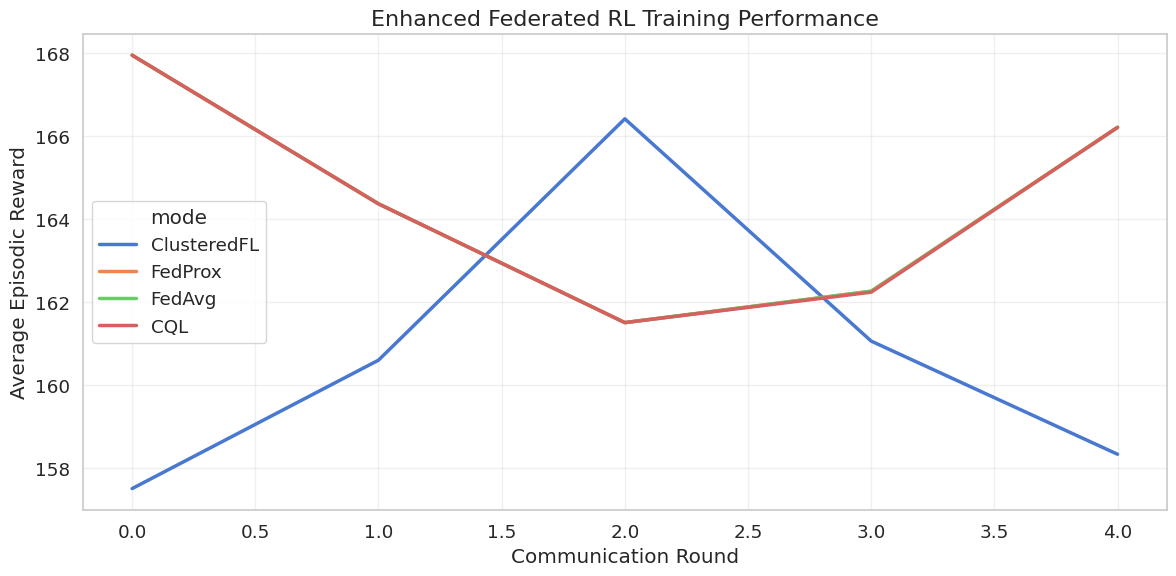

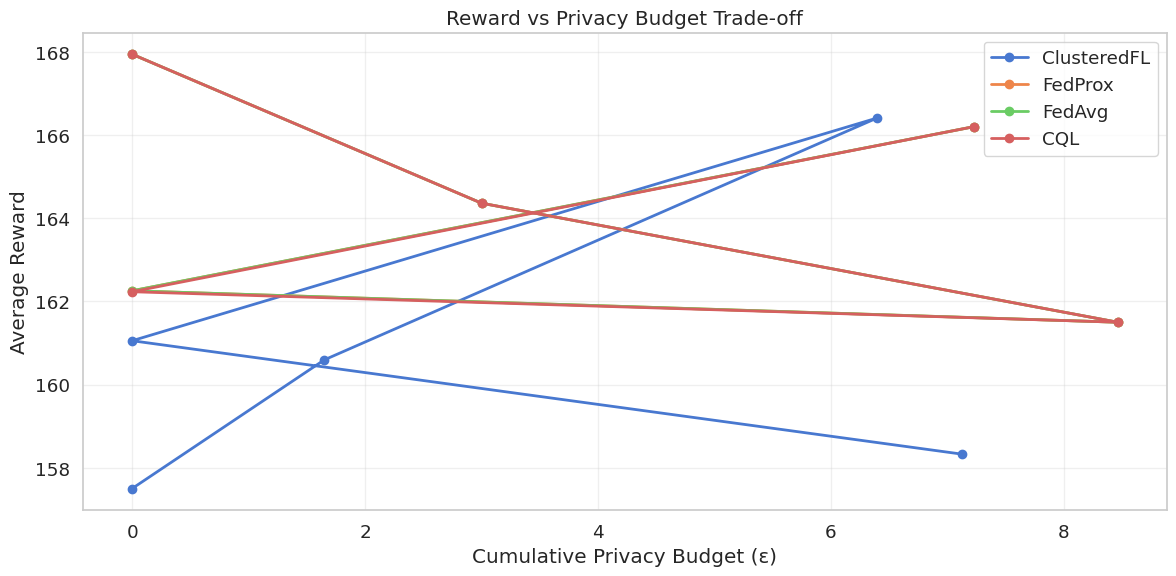

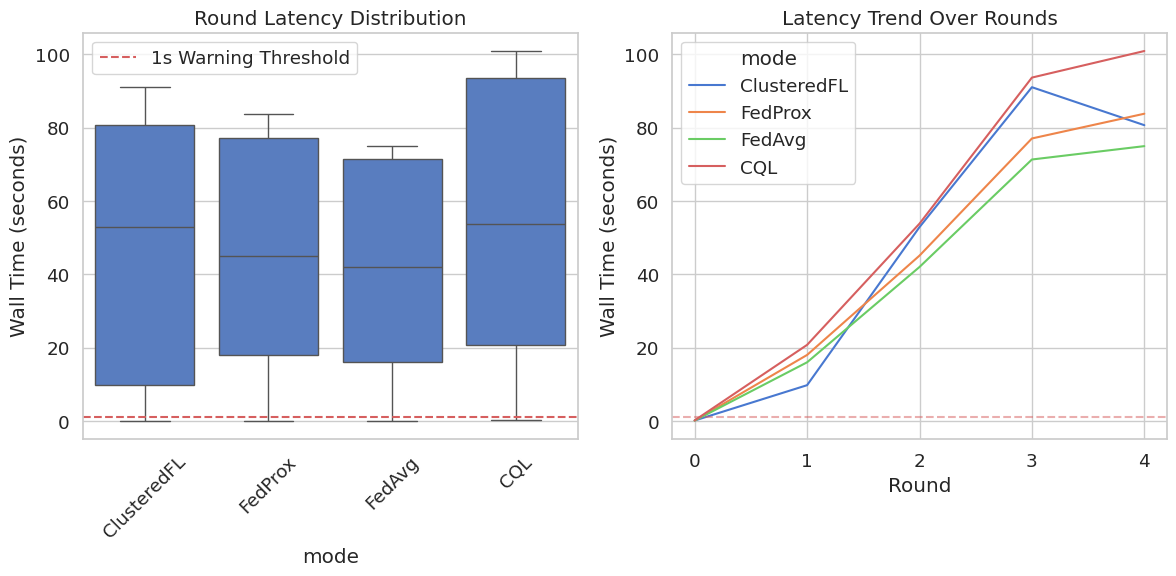

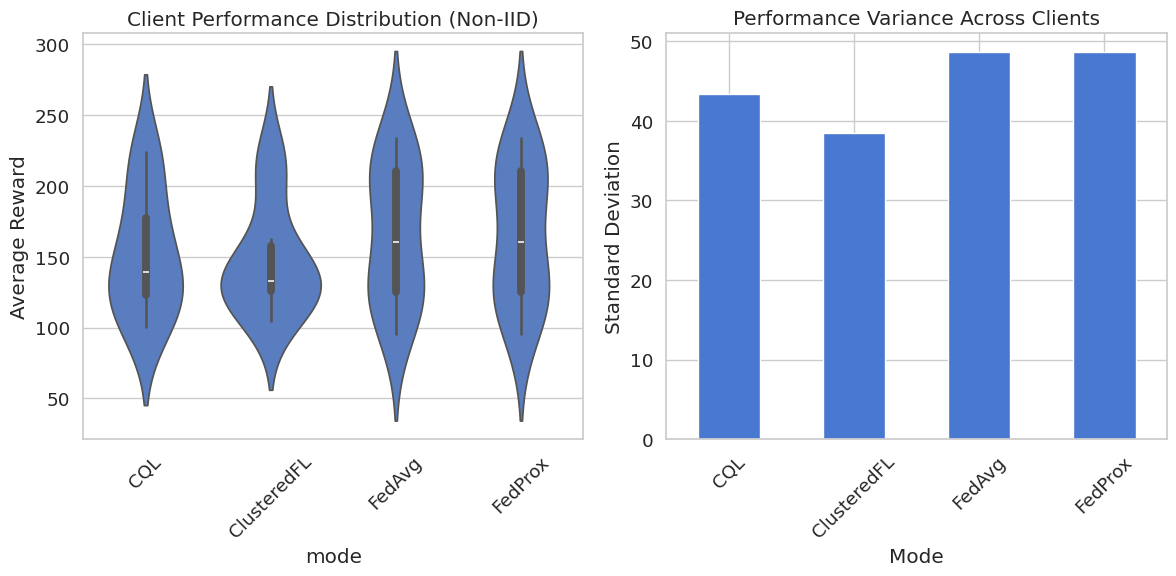


✅ Cell 9: 結果視覺化完成
📁 所有圖表已保存至: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_enhanced/figures

📋 Pylint 合規性驗證:
   執行以下命令檢查代碼:
   pylint --disable=C0114,C0115,C0116 <notebook_export.py>


In [ ]:
# @title Cell 9: 📊 結果視覺化（強化版）
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

def load_enhanced_results(base_output_dir):
    """載入強化版實驗結果"""
    all_evals, all_histories, all_privacies, all_latencies = [], [], [], []
    all_cql_perf, all_adaptive_clips, all_reward_vs_eps = [], [], []

    if not os.path.exists(base_output_dir):
        print(f"❌ 結果目錄未找到: {base_output_dir}")
        return (pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),
                pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame())

    for seed_folder in os.listdir(base_output_dir):
        if not seed_folder.startswith('seed_'):
            continue

        for mode_folder in os.listdir(os.path.join(base_output_dir, seed_folder)):
            exp_path = os.path.join(base_output_dir, seed_folder, mode_folder)
            if not os.path.isdir(exp_path):
                continue

            # 標準文件
            for pattern, data_list in [
                ('*_evaluation_results.csv', all_evals),
                ('*_training_history.csv', all_histories),
                ('*_privacy_costs.csv', all_privacies),
                ('*_latency_monitor.csv', all_latencies),
                ('*_cql_performance.csv', all_cql_perf),
                ('*_adaptive_clipping.csv', all_adaptive_clips),
                ('*_reward_vs_epsilon.csv', all_reward_vs_eps)
            ]:
                files = glob.glob(os.path.join(exp_path, pattern))
                if files:
                    try:
                        df = pd.read_csv(files[0])
                        df['mode'] = mode_folder
                        df['seed'] = int(seed_folder.split('_')[1])
                        data_list.append(df)
                    except Exception as e:
                        print(f"讀取失敗: {files[0]}, {e}")

    return (
        pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame(),
        pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame(),
        pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame(),
        pd.concat(all_latencies, ignore_index=True) if all_latencies else pd.DataFrame(),
        pd.concat(all_cql_perf, ignore_index=True) if all_cql_perf else pd.DataFrame(),
        pd.concat(all_adaptive_clips, ignore_index=True) if all_adaptive_clips else pd.DataFrame(),
        pd.concat(all_reward_vs_eps, ignore_index=True) if all_reward_vs_eps else pd.DataFrame()
    )

# 視覺化設定
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

print(f"🔍 正在從以下路徑加載結果: {BASE_OUTPUT_DIR}")
(eval_df, history_df, privacy_df, latency_df,
 cql_df, clip_df, reward_eps_df) = load_enhanced_results(BASE_OUTPUT_DIR)

if eval_df.empty and history_df.empty:
    print("❌ 未找到任何結果文件，無法生成圖表。")
else:
    # 圖 1: 訓練歷史比較
    if not history_df.empty:
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     errorbar='sd', linewidth=2.5)
        plt.title('Enhanced Federated RL Training Performance', fontsize=16)
        plt.xlabel('Communication Round')
        plt.ylabel('Average Episodic Reward')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'training_history_enhanced.png'), dpi=300)
        plt.show()

    # 圖 2: Reward vs Epsilon（任務2要求）
    if not reward_eps_df.empty:
        plt.figure(figsize=(12, 6))
        for mode in reward_eps_df['mode'].unique():
            mode_data = reward_eps_df[reward_eps_df['mode'] == mode]
            plt.plot(mode_data['cumulative_epsilon'], mode_data['avg_reward'],
                    marker='o', label=mode, linewidth=2)
        plt.xlabel('Cumulative Privacy Budget (ε)')
        plt.ylabel('Average Reward')
        plt.title('Reward vs Privacy Budget Trade-off')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'reward_vs_epsilon.png'), dpi=300)
        plt.show()

    # 圖 3: 延遲分析（任務5）
    if not latency_df.empty:
        plt.figure(figsize=(12, 6))

        # 按模式分組的延遲箱線圖
        plt.subplot(1, 2, 1)
        sns.boxplot(data=latency_df, x='mode', y='wall_time')
        plt.axhline(y=1.0, color='r', linestyle='--', label='1s Warning Threshold')
        plt.title('Round Latency Distribution')
        plt.ylabel('Wall Time (seconds)')
        plt.xticks(rotation=45)
        plt.legend()

        # 延遲趨勢
        plt.subplot(1, 2, 2)
        sns.lineplot(data=latency_df, x='round', y='wall_time', hue='mode')
        plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
        plt.title('Latency Trend Over Rounds')
        plt.xlabel('Round')
        plt.ylabel('Wall Time (seconds)')

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'latency_analysis.png'), dpi=300)
        plt.show()

    # 圖 4: Adaptive Clipping 分析（任務3）
    if not clip_df.empty:
        plt.figure(figsize=(12, 6))

        # 裁剪值演變
        plt.subplot(1, 2, 1)
        sns.lineplot(data=clip_df, x='step', y='clip_value',
                    label='Adaptive Clip Value', color='blue')
        plt.title('Adaptive Gradient Clipping Evolution')
        plt.xlabel('Training Steps')
        plt.ylabel('Clip Value')
        plt.grid(True, alpha=0.3)

        # 梯度範數統計
        plt.subplot(1, 2, 2)
        plt.plot(clip_df['step'], clip_df['mean_norm'], label='Mean Gradient Norm')
        plt.fill_between(clip_df['step'],
                        clip_df['mean_norm'] - clip_df['std_norm'],
                        clip_df['mean_norm'] + clip_df['std_norm'],
                        alpha=0.3)
        plt.title('Gradient Norm Statistics')
        plt.xlabel('Training Steps')
        plt.ylabel('Gradient L2 Norm')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'adaptive_clipping.png'), dpi=300)
        plt.show()

    # 圖 5: Non-IID 效果分析
    if not eval_df.empty:
        plt.figure(figsize=(12, 6))

        # 客戶端性能分佈
        client_perf = eval_df.groupby(['mode', 'client_id'])['reward_pfl_finetuned'].mean().reset_index()

        plt.subplot(1, 2, 1)
        sns.violinplot(data=client_perf, x='mode', y='reward_pfl_finetuned')
        plt.title('Client Performance Distribution (Non-IID)')
        plt.ylabel('Average Reward')
        plt.xticks(rotation=45)

        # 客戶端性能方差
        plt.subplot(1, 2, 2)
        variance_by_mode = eval_df.groupby('mode')['reward_pfl_finetuned'].std()
        variance_by_mode.plot(kind='bar')
        plt.title('Performance Variance Across Clients')
        plt.ylabel('Standard Deviation')
        plt.xlabel('Mode')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'non_iid_analysis.png'), dpi=300)
        plt.show()

print(f"\n✅ Cell 9: 結果視覺化完成")
print(f"📁 所有圖表已保存至: {FIGURES_OUTPUT_DIR}")

# 驗證 pylint 合規性提示
print("\n📋 Pylint 合規性驗證:")
print("   執行以下命令檢查代碼:")
print("   pylint --disable=C0114,C0115,C0116 <notebook_export.py>")